In [6]:
import os, re
import pandas as pd
import datetime
import nltk
import numpy as np
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
from gensim import corpora, models, similarities 
from gensim.parsing.preprocessing import remove_stopwords
import spacy
import itertools
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
matplotlib.use('agg')
import itertools
import pickle
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [254]:
stops = nltk.corpus.stopwords.words('english')
rmwords = ['can','will','also','health','healthcare','datum','compani','use',
                                               'technology','technolog','care','busi','custom','year']

In [255]:
#stops = get_stop_words('en')
#stops = stops +['"s',"'s",'s','can','will','also']

In [256]:
#pt = nltk.stem.PorterStemmer()

In [257]:
nlp = spacy.load('en')#, disable=['parser', 'ner'])

In [258]:
#spacy.load('en')

In [259]:
rootDir = '../LDA/'
d = {}
wh = []
for dirName, subdirList, fileList in os.walk(rootDir) :
    print('Found directory: %s' % dirName)
    #print(dirName)
    #print(len(fileList))
    c = 0

    if dirName !='../LDA/.ipynb_checkpoints' and dirName != '../LDA/'\
    and dirName != '../LDA/fintech_re':
        print(dirName)
        news_name = dirName.replace('../LDA/','')
        d[news_name] = {}
        c = 0
        for fname in fileList: 
            if fname.endswith(".txt"):  
                filepath = os.path.join(dirName, fname)
                with open(filepath, 'r', -1) as input_file:
                    data = input_file.read()
                    #print(data)
                    if data != '':
                        try:                                
                            if news_name == 'healthitarticle':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != ''and 'tagged' not in item.lower()]
                                body = re.sub(r'\w+\s\d{1,2}\,\s\d{4}\s\-\s+','', tls[3])
                                tls[3] = re.sub('LAS VEGAS – ','', body)
                                whole_text = " ".join(tls[3:]) 
                            if news_name == 'aitho':
                                c+=1
                                if fname == 'aitho_article_1792.txt':
                                    date = re.findall(r'\d{1,2}\s\w+\s\d{4}', data)[1]
                                else:
                                    date = re.search(r'\d{1,2}\s\w+\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%d %b %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'fintech':
                                c+=1
                                date = re.search(r'\w+\s\d{1,2}\,\s\d{4}', data).group(0)
                                date_obj = datetime.strptime(date, '%B %d, %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 
                            if news_name == 'reinsu':
                                c +=1
                                date = re.search(r'\d{1,2}\w+\s\w+\s\d{4}', data).group(0)
                                date = re.sub(r'(?<=[0-9])(?:st|nd|rd|th)', '',date)
                                date_obj = datetime.strptime(date, '%d %B %Y')
                                tls = [item for item in data.split('\n') if item != '']
                                whole_text = " ".join(tls[2:]) 

                        except Exception as e:
                            print(news_name, fname)
                            print(e)
            d[news_name][c] = {'date':date_obj, 'text':whole_text, 
                                'whole':tls, 'filepath':filepath}

In [260]:
#[item for item in data.split('\n') if item != '' and 'tagged' not in item.lower()]
#[item for item in tp if item != '' and 'tagged' not in item.lower()]

In [261]:
#tp = d['healthitarticle'][1]['whole']
#tp

In [262]:
for i, v in d.items():
    print(i, len(v))

In [263]:
temp = {}
for news_name, values1 in d.items():
    for number, values2 in values1.items():
        temp.setdefault('newsname', []).append(news_name)
        temp.setdefault('number', []).append(number)
        for key, value in values2.items():
            #for key, value in date.items():
            temp.setdefault(key, []).append(value)

In [264]:
df_orig = pd.DataFrame(temp)

In [265]:
df = df_orig[df_orig['newsname']!='healthitarticle']

KeyError: 'newsname'

In [ ]:
df[['date','newsname','text','whole']].shape[0]

In [ ]:
df_clean = df.drop_duplicates(subset=['date','newsname','text'])

In [ ]:
df_drop = df[df.duplicated(subset=['date','newsname','text'])]

In [ ]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [ ]:
df_clean['year'] = df_clean['date'].dt.year

In [ ]:
df_clean['month'] = df_clean['date'].dt.month

In [ ]:
df_clean.groupby(['year','month']).count()

In [ ]:
#df_clean.to_csv('insuretech_newspaper_wo_health_addmonth.csv', index = False)

In [12]:
df_clean = pd.read_csv('insuretech_newspaper_wo_health.csv')

In [13]:
text_ls = list(df_clean['text'])

In [223]:
from gensim.parsing.preprocessing import stem_text, strip_punctuation, strip_punctuation2

In [224]:
total_text = text_ls

In [266]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [267]:
def tokenized_gensim(total_text):
    tokenized_text = []
    for k, text_raw in enumerate(total_text):
        text = re.sub('\n', ' ', text_raw, flags= re.IGNORECASE) 
        text = re.sub(r'\((?!k\))(?!b\))(.*?)\)',' ', text, flags= re.IGNORECASE)
        try:
            tokens = [word for sent in nltk.sent_tokenize(text) \
              for word in nltk.word_tokenize(sent) if word.lower() not in stops]              
            filtered_tokens = []
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    token = re.sub(r'[^\w\s]', '', token)
                    filtered_tokens.append(token.lower())
            stems = [stemmer.stem(t) for t in filtered_tokens if t not in stops]
            stems = [word for word in stems if word not in stops]
            tokenized_text.append(stems)
        except Exception as e:
            print(e)
            print(k)
    return tokenized_text

In [268]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stops] for doc in texts]

def make_bigrams(bigram_mod, texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        #print(sent)
        doc = nlp(" ".join(sent))
        #print(doc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in stops\
                         and token.lemma_ not in rmwords])
    return texts_out

In [269]:
# Tokenized, remove stop words, stemming the whole texts
%time data_words = tokenized_gensim(total_text)

CPU times: user 54.1 s, sys: 4.24 ms, total: 54.1 s
Wall time: 54.1 s


In [270]:
# Build the bigram and trigram models
%time bigram = gensim.models.Phrases(data_words,\
                                     min_count=5, threshold=5) 
# higher threshold fewer phrases.
%time trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod = gensim.models.phrases.Phraser(bigram)
%time trigram_mod = gensim.models.phrases.Phraser(trigram)

2018-07-19 13:33:12,424 : INFO : collecting all words and their counts
2018-07-19 13:33:12,426 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-07-19 13:33:14,811 : INFO : collected 621153 word types from a corpus of 1067190 words (unigram + bigrams) and 3319 sentences
2018-07-19 13:33:14,813 : INFO : using 621153 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
2018-07-19 13:33:14,850 : INFO : collecting all words and their counts
2018-07-19 13:33:14,852 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


CPU times: user 2.43 s, sys: 0 ns, total: 2.43 s
Wall time: 2.42 s


2018-07-19 13:33:22,707 : INFO : collected 689815 word types from a corpus of 953715 words (unigram + bigrams) and 3319 sentences
2018-07-19 13:33:22,708 : INFO : using 689815 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>
2018-07-19 13:33:22,747 : INFO : source_vocab length 621153


CPU times: user 7.88 s, sys: 20.3 ms, total: 7.9 s
Wall time: 7.9 s


2018-07-19 13:33:31,543 : INFO : Phraser built with 6275 6275 phrasegrams
2018-07-19 13:33:31,553 : INFO : source_vocab length 689815


CPU times: user 8.8 s, sys: 5.91 ms, total: 8.81 s
Wall time: 8.81 s


2018-07-19 13:33:43,268 : INFO : Phraser built with 8743 8743 phrasegrams


CPU times: user 11.7 s, sys: 17.7 ms, total: 11.7 s
Wall time: 11.7 s


In [271]:
# Remove Stop Words
%time data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
%time data_words_bigrams = make_bigrams(bigram_mod, data_words_nostops)

CPU times: user 5.03 s, sys: 17.6 ms, total: 5.05 s
Wall time: 5.05 s
CPU times: user 3.48 s, sys: 39.9 ms, total: 3.52 s
Wall time: 3.52 s


In [272]:
# Form Trigrams
%time data_words_trigrams = make_trigrams(data_words_nostops)

CPU times: user 6.87 s, sys: 0 ns, total: 6.87 s
Wall time: 6.87 s


In [273]:
#len(data_lemmatized_tri[100])

In [274]:
# # Do lemmatization keeping only noun, adj, vb, adv
# print(datetime.now())
# %time data_lemmatized = lemmatization(data_words_bigrams,\
#                                       allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])
# print(datetime.now())

In [275]:
# Do lemmatization keeping only noun, adj, vb, adv with tri
print(datetime.now())
%time data_lemmatized_tri = lemmatization(data_words_trigrams,\
                                      allowed_postags=['NOUN'])
print(datetime.now())

2018-07-19 13:33:58.766836
CPU times: user 23min 58s, sys: 51min 20s, total: 1h 15min 18s
Wall time: 5min 1s
2018-07-19 13:39:00.260739


In [276]:
print(datetime.now())
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(data_lemmatized_tri)

print(datetime.now())
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=2, no_above=0.6)
print(datetime.now())

2018-07-19 13:39:00,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


2018-07-19 13:39:00.272859


2018-07-19 13:39:00,947 : INFO : built Dictionary(32082 unique tokens: ['ohmni', 'cbot', 'teamview', 'procur_process', 'fuzzymatch']...) from 3319 documents (total 521675 corpus positions)
2018-07-19 13:39:00,995 : INFO : discarding 16442 tokens: [('iwoca', 1), ('much_higher', 1), ('riech', 1), ('tharmarajah', 1), ('thinfil', 1), ('reregist', 1), ('davdra', 1), ('paresh', 1), ('ayear', 1), ('consign', 1)]...
2018-07-19 13:39:00,996 : INFO : keeping 15640 tokens which were in no less than 2 and no more than 1991 (=60.0%) documents
2018-07-19 13:39:01,019 : INFO : resulting dictionary: Dictionary(15640 unique tokens: ['small_midsiz', 'xiaomi', 'procur_process', 'mode', 'fruition']...)


CPU times: user 973 ms, sys: 798 ms, total: 1.77 s
Wall time: 675 ms
2018-07-19 13:39:00.948659
CPU times: user 22.5 ms, sys: 52.2 ms, total: 74.7 ms
Wall time: 72.5 ms
2018-07-19 13:39:01.022310


In [277]:
dicls = list(dictionary.values())

In [278]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in data_lemmatized_tri]

CPU times: user 465 ms, sys: 0 ns, total: 465 ms
Wall time: 464 ms


In [359]:
####### LDA model
%time ldamodel = models.LdaModel(corpus, num_topics=10, \
                                   id2word=dictionary, update_every=1,\
                                 chunksize=1250, passes=20)

2018-07-19 17:12:21,573 : INFO : using symmetric alpha at 0.1
2018-07-19 17:12:21,575 : INFO : using symmetric eta at 0.1
2018-07-19 17:12:21,580 : INFO : using serial LDA version on this node
2018-07-19 17:12:21,604 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 3319 documents, updating model once every 1250 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-19 17:12:21,605 : INFO : PROGRESS: pass 0, at document #1250/3319
2018-07-19 17:12:22,748 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:22,770 : INFO : topic #6 (0.100): 0.010*"investor" + 0.009*"market" + 0.006*"product" + 0.006*"fund" + 0.005*"bank" + 0.005*"process" + 0.005*"platform" + 0.005*"payment" + 0.004*"user" + 0.004*"support"
2018-07-19 17:12:22,772 : INFO : topic #5 (0.100): 0.012*"bank" + 0.007*"manag" + 0.007*"work" + 0.007*"financi" + 0.007*"product" 

2018-07-19 17:12:30,168 : INFO : topic #1 (0.100): 0.024*"platform" + 0.013*"blockchain" + 0.012*"cryptocurr" + 0.007*"user" + 0.007*"market" + 0.006*"transact" + 0.006*"exchang" + 0.006*"design" + 0.005*"process" + 0.005*"access"
2018-07-19 17:12:30,170 : INFO : topic #6 (0.100): 0.014*"sale" + 0.011*"market" + 0.010*"user" + 0.009*"platform" + 0.008*"campaign" + 0.007*"product" + 0.006*"mobil" + 0.006*"app" + 0.006*"pega" + 0.005*"contact_center"
2018-07-19 17:12:30,172 : INFO : topic diff=0.655106, rho=0.463480
2018-07-19 17:12:30,173 : INFO : PROGRESS: pass 2, at document #1250/3319
2018-07-19 17:12:31,138 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:31,160 : INFO : topic #9 (0.100): 0.010*"innov" + 0.008*"system" + 0.007*"oper" + 0.007*"platform" + 0.006*"payment" + 0.006*"manag" + 0.006*"work" + 0.006*"market" + 0.006*"drone" + 0.005*"robot"
2018-07-19 17:12:31,161 : INFO : topic #0 (0.100): 0.025*"market" + 0.009*"platform" + 0.009

2018-07-19 17:12:37,081 : INFO : topic #2 (0.100): 0.014*"platform" + 0.011*"cloud" + 0.010*"manag" + 0.009*"servic" + 0.008*"client" + 0.008*"enterpris" + 0.007*"partner" + 0.007*"capabl" + 0.007*"team" + 0.007*"process"
2018-07-19 17:12:37,083 : INFO : topic #8 (0.100): 0.012*"video" + 0.009*"game" + 0.008*"robot" + 0.006*"market" + 0.006*"world" + 0.005*"educ" + 0.005*"work" + 0.005*"content" + 0.005*"product" + 0.005*"innov"
2018-07-19 17:12:37,084 : INFO : topic diff=0.303913, rho=0.387632
2018-07-19 17:12:37,086 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:12:37,917 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:37,939 : INFO : topic #2 (0.100): 0.013*"platform" + 0.010*"manag" + 0.010*"cloud" + 0.010*"client" + 0.009*"servic" + 0.007*"partner" + 0.007*"enterpris" + 0.007*"process" + 0.007*"capabl" + 0.007*"team"
2018-07-19 17:12:37,941 : INFO : topic #0 (0.100): 0.029*"market" + 0.010*"research" + 0.009*"product" +

2018-07-19 17:12:43,491 : INFO : topic #7 (0.100): 0.015*"innov" + 0.011*"digit" + 0.007*"event" + 0.007*"partner" + 0.007*"market" + 0.007*"group" + 0.006*"work" + 0.006*"world" + 0.006*"consum" + 0.006*"ceo"
2018-07-19 17:12:43,493 : INFO : topic #6 (0.100): 0.021*"sale" + 0.018*"market" + 0.017*"campaign" + 0.012*"app" + 0.012*"user" + 0.011*"platform" + 0.011*"ad" + 0.007*"product" + 0.006*"mobil" + 0.006*"pega"
2018-07-19 17:12:43,495 : INFO : topic diff=0.191706, rho=0.339908
2018-07-19 17:12:43,497 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:12:44,285 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:44,307 : INFO : topic #2 (0.100): 0.016*"platform" + 0.011*"manag" + 0.011*"cloud" + 0.010*"client" + 0.010*"servic" + 0.008*"enterpris" + 0.008*"partner" + 0.008*"capabl" + 0.008*"process" + 0.007*"product"
2018-07-19 17:12:44,309 : INFO : topic #3 (0.100): 0.019*"bank" + 0.010*"market" + 0.009*"fintech" + 0.009*"invest

2018-07-19 17:12:50,150 : INFO : topic #6 (0.100): 0.022*"market" + 0.021*"sale" + 0.018*"campaign" + 0.013*"app" + 0.012*"ad" + 0.012*"platform" + 0.012*"user" + 0.007*"advertis" + 0.007*"brand" + 0.007*"product"
2018-07-19 17:12:50,151 : INFO : topic #0 (0.100): 0.031*"market" + 0.014*"research" + 0.011*"artifici_intellig" + 0.008*"product" + 0.007*"innov" + 0.007*"platform" + 0.007*"team" + 0.007*"system" + 0.006*"content" + 0.005*"work"
2018-07-19 17:12:50,153 : INFO : topic diff=0.145998, rho=0.306351
2018-07-19 17:12:50,154 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:12:50,913 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:50,935 : INFO : topic #7 (0.100): 0.017*"innov" + 0.011*"digit" + 0.008*"event" + 0.007*"partner" + 0.007*"work" + 0.007*"group" + 0.006*"world" + 0.006*"market" + 0.006*"ceo" + 0.006*"consum"
2018-07-19 17:12:50,936 : INFO : topic #8 (0.100): 0.012*"video" + 0.012*"game" + 0.007*"content" + 0.00

2018-07-19 17:12:56,152 : INFO : topic #8 (0.100): 0.015*"game" + 0.015*"video" + 0.010*"content" + 0.007*"educ" + 0.006*"world" + 0.006*"work" + 0.006*"student" + 0.006*"peopl" + 0.006*"team" + 0.006*"medium"
2018-07-19 17:12:56,153 : INFO : topic #1 (0.100): 0.027*"blockchain" + 0.024*"platform" + 0.015*"cryptocurr" + 0.011*"transact" + 0.010*"user" + 0.009*"blockchain_technolog" + 0.008*"exchang" + 0.008*"network" + 0.007*"trade" + 0.007*"project"
2018-07-19 17:12:56,155 : INFO : topic diff=0.122403, rho=0.281103
2018-07-19 17:12:56,156 : INFO : PROGRESS: pass 10, at document #1250/3319
2018-07-19 17:12:56,892 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:12:56,914 : INFO : topic #4 (0.100): 0.013*"product" + 0.013*"devic" + 0.009*"platform" + 0.008*"design" + 0.008*"system" + 0.008*"connect" + 0.008*"featur" + 0.007*"power" + 0.007*"user" + 0.007*"display"
2018-07-19 17:12:56,915 : INFO : topic #9 (0.100): 0.014*"system" + 0.012*"robot" +

2018-07-19 17:13:02,043 : INFO : topic #2 (0.100): 0.020*"platform" + 0.014*"manag" + 0.012*"cloud" + 0.011*"servic" + 0.010*"client" + 0.010*"enterpris" + 0.009*"partner" + 0.009*"capabl" + 0.008*"process" + 0.008*"product"
2018-07-19 17:13:02,046 : INFO : topic #1 (0.100): 0.028*"blockchain" + 0.025*"platform" + 0.016*"cryptocurr" + 0.011*"transact" + 0.010*"user" + 0.009*"blockchain_technolog" + 0.008*"exchang" + 0.008*"network" + 0.007*"trade" + 0.007*"project"
2018-07-19 17:13:02,048 : INFO : topic diff=0.107793, rho=0.261219
2018-07-19 17:13:02,050 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:13:02,785 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:13:02,808 : INFO : topic #0 (0.100): 0.030*"market" + 0.015*"research" + 0.011*"artifici_intellig" + 0.008*"product" + 0.007*"team" + 0.007*"innov" + 0.006*"system" + 0.006*"platform" + 0.006*"work" + 0.006*"content"
2018-07-19 17:13:02,809 : INFO : topic #9 (0.100): 0.014*

2018-07-19 17:13:07,850 : INFO : topic #1 (0.100): 0.029*"blockchain" + 0.025*"platform" + 0.016*"cryptocurr" + 0.012*"transact" + 0.010*"user" + 0.009*"blockchain_technolog" + 0.008*"exchang" + 0.008*"network" + 0.007*"trade" + 0.007*"project"
2018-07-19 17:13:07,851 : INFO : topic #5 (0.100): 0.011*"manag" + 0.009*"user" + 0.009*"product" + 0.009*"organ" + 0.009*"autom" + 0.009*"platform" + 0.008*"inform" + 0.008*"process" + 0.008*"percent" + 0.007*"time"
2018-07-19 17:13:07,853 : INFO : topic diff=0.097630, rho=0.245033
2018-07-19 17:13:07,854 : INFO : PROGRESS: pass 14, at document #1250/3319
2018-07-19 17:13:08,582 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:13:08,604 : INFO : topic #4 (0.100): 0.014*"product" + 0.013*"devic" + 0.009*"platform" + 0.009*"design" + 0.008*"system" + 0.008*"connect" + 0.008*"featur" + 0.008*"power" + 0.007*"display" + 0.007*"user"
2018-07-19 17:13:08,606 : INFO : topic #3 (0.100): 0.019*"bank" + 0.011*"mar

2018-07-19 17:13:14,539 : INFO : topic #1 (0.100): 0.029*"blockchain" + 0.025*"platform" + 0.016*"cryptocurr" + 0.012*"transact" + 0.010*"user" + 0.009*"blockchain_technolog" + 0.008*"exchang" + 0.008*"network" + 0.008*"trade" + 0.007*"project"
2018-07-19 17:13:14,541 : INFO : topic #4 (0.100): 0.015*"product" + 0.013*"devic" + 0.010*"platform" + 0.009*"system" + 0.009*"design" + 0.009*"connect" + 0.008*"display" + 0.008*"featur" + 0.008*"power" + 0.007*"user"
2018-07-19 17:13:14,542 : INFO : topic diff=0.089819, rho=0.231526
2018-07-19 17:13:14,548 : INFO : PROGRESS: pass 16, at document #1250/3319
2018-07-19 17:13:15,734 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:13:15,756 : INFO : topic #5 (0.100): 0.011*"manag" + 0.010*"user" + 0.009*"product" + 0.009*"autom" + 0.008*"inform" + 0.008*"platform" + 0.008*"organ" + 0.008*"process" + 0.008*"time" + 0.007*"percent"
2018-07-19 17:13:15,758 : INFO : topic #6 (0.100): 0.033*"market" + 0.021*"s

2018-07-19 17:13:21,303 : INFO : topic #9 (0.100): 0.015*"robot" + 0.015*"system" + 0.013*"oper" + 0.011*"vehicl" + 0.011*"drone" + 0.007*"innov" + 0.007*"mobil" + 0.005*"manag" + 0.005*"car" + 0.005*"transport"
2018-07-19 17:13:21,304 : INFO : topic #5 (0.100): 0.011*"manag" + 0.010*"user" + 0.009*"organ" + 0.009*"product" + 0.009*"autom" + 0.008*"inform" + 0.008*"platform" + 0.008*"percent" + 0.008*"process" + 0.007*"time"
2018-07-19 17:13:21,306 : INFO : topic diff=0.083647, rho=0.220032
2018-07-19 17:13:21,308 : INFO : PROGRESS: pass 18, at document #1250/3319
2018-07-19 17:13:22,019 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:13:22,041 : INFO : topic #7 (0.100): 0.019*"innov" + 0.011*"digit" + 0.009*"event" + 0.008*"partner" + 0.007*"group" + 0.007*"work" + 0.007*"world" + 0.006*"ceo" + 0.006*"network" + 0.006*"support"
2018-07-19 17:13:22,043 : INFO : topic #5 (0.100): 0.011*"manag" + 0.010*"user" + 0.009*"product" + 0.008*"autom" + 0

2018-07-19 17:13:27,004 : INFO : topic #7 (0.100): 0.018*"innov" + 0.011*"digit" + 0.009*"event" + 0.008*"partner" + 0.008*"group" + 0.007*"world" + 0.007*"work" + 0.007*"ceo" + 0.006*"network" + 0.006*"team"
2018-07-19 17:13:27,005 : INFO : topic #3 (0.100): 0.018*"bank" + 0.011*"market" + 0.008*"fintech" + 0.008*"investor" + 0.008*"regul" + 0.007*"risk" + 0.007*"financi" + 0.006*"innov" + 0.006*"process" + 0.006*"invest"
2018-07-19 17:13:27,007 : INFO : topic diff=0.078759, rho=0.210095


CPU times: user 1min 5s, sys: 931 ms, total: 1min 5s
Wall time: 1min 5s


In [360]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15, num_topics=25)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

allls = []
allls1 = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)
    allls1.append([wordls])

['market', 'research', 'artifici_intellig', 'team', 'product', 'system', 'innov', 'ai', 'work', 'content', 'platform', 'train', 'project', 'univer', 'base']
['blockchain', 'platform', 'cryptocurr', 'transact', 'user', 'blockchain_technolog', 'exchang', 'network', 'trade', 'project', 'system', 'access', 'payment', 'market', 'launch']
['platform', 'manag', 'cloud', 'servic', 'enterpris', 'client', 'partner', 'capabl', 'process', 'product', 'support', 'innov', 'team', 'insight', 'oper']
['bank', 'market', 'fintech', 'investor', 'regul', 'risk', 'financi', 'innov', 'process', 'invest', 'client', 'sector', 'fund', 'financ', 'payment']
['product', 'devic', 'platform', 'system', 'design', 'connect', 'display', 'featur', 'power', 'user', 'sensor', 'hardwar', 'comput', 'model', 'support']
['manag', 'user', 'organ', 'product', 'autom', 'inform', 'platform', 'percent', 'process', 'time', 'person', 'intellig', 'system', 'servic', 'network']
['market', 'brand', 'sale', 'campaign', 'platform', 'ad',

In [361]:
pd.DataFrame(allls)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,market,research,artifici_intellig,team,product,system,innov,ai,work,content,platform,train,project,univer,base
1,blockchain,platform,cryptocurr,transact,user,blockchain_technolog,exchang,network,trade,project,system,access,payment,market,launch
2,platform,manag,cloud,servic,enterpris,client,partner,capabl,process,product,support,innov,team,insight,oper
3,bank,market,fintech,investor,regul,risk,financi,innov,process,invest,client,sector,fund,financ,payment
4,product,devic,platform,system,design,connect,display,featur,power,user,sensor,hardwar,comput,model,support
5,manag,user,organ,product,autom,inform,platform,percent,process,time,person,intellig,system,servic,network
6,market,brand,sale,campaign,platform,ad,consum,app,user,advertis,product,engag,mobil,audienc,merchant
7,innov,digit,event,partner,group,world,work,ceo,network,team,support,communiti,collabor,startup,leader
8,game,video,content,educ,peopl,world,work,student,medium,player,team,creat,studio,way,entertain
9,robot,system,oper,vehicl,drone,innov,mobil,car,transport,manag,test,product,autonom,work,manufactur


In [362]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(dataprepared)

In [105]:
pyLDAvis.save_html(dataprepared, 'lda_tri.html')

In [218]:
## SAVE 
dictionary.save('dictionary_tri.dict')
corpora.MmCorpus.serialize('corpus_tri.mm', corpus)

2018-07-19 13:12:03,324 : INFO : saving Dictionary object under dictionary_tri.dict, separately None
2018-07-19 13:12:03,330 : INFO : saved dictionary_tri.dict
2018-07-19 13:12:03,331 : INFO : storing corpus in Matrix Market format to corpus_tri.mm
2018-07-19 13:12:03,333 : INFO : saving sparse matrix to corpus_tri.mm
2018-07-19 13:12:03,333 : INFO : PROGRESS: saving document #0
2018-07-19 13:12:03,505 : INFO : PROGRESS: saving document #1000
2018-07-19 13:12:03,644 : INFO : PROGRESS: saving document #2000
2018-07-19 13:12:03,798 : INFO : PROGRESS: saving document #3000
2018-07-19 13:12:03,845 : INFO : saved 3319x8389 matrix, density=1.160% (322963/27843091)
2018-07-19 13:12:03,846 : INFO : saving MmCorpus index to corpus_tri.mm.index


In [45]:
## SAVE TEXTS
with open("data_lemmetized_tri.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)

In [46]:
### SAVE MODEL
ldamodel.save('ldamodel_tri.model')

2018-07-19 09:31:58,064 : INFO : saving LdaState object under ldamodel_tri.model.state, separately None
2018-07-19 09:31:58,068 : INFO : saved ldamodel_tri.model.state
2018-07-19 09:31:58,073 : INFO : saving LdaModel object under ldamodel_tri.model, separately ['expElogbeta', 'sstats']
2018-07-19 09:31:58,073 : INFO : not storing attribute dispatcher
2018-07-19 09:31:58,074 : INFO : not storing attribute state
2018-07-19 09:31:58,075 : INFO : not storing attribute id2word
2018-07-19 09:31:58,076 : INFO : storing np array 'expElogbeta' to ldamodel_tri.model.expElogbeta.npy
2018-07-19 09:31:58,081 : INFO : saved ldamodel_tri.model


In [ ]:
## LOAD
dictionary = gensim.corpora.Dictionary.load('dictionary_tri.dict')
corpus = gensim.corpora.MmCorpus('corpus_tri.mm')
ldamodel = gensim.models.ldamodel.LdaModel.load('ldamodel_tri.model')
with open("data_lemmetized_tri.txt",'rb')as f:
    data_lemmatized = pickle.load(f)
    f.close()

In [ ]:
dictionary.num_pos

In [ ]:
dictionary.num_nnz

# Finding optimal number of topics

In [363]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, step))
    parameter_list[0] = start
    grid ={}
    cv_dic = {}
    for num_topics in parameter_list:
        print(num_topics)

        model = models.LdaModel(corpus, num_topics=num_topics, \
                                   id2word=dictionary, update_every=1,\
                                 chunksize=1250, passes=20)
        model_list.append(model)
        perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        cv_dic[num_topics]=[]
        cv_dic[num_topics].append(coherencemodel.get_coherence())

    return model_list, cv_dic, grid

In [ ]:
print(datetime.now())
%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=dictionary,\
                                                                           corpus=corpus,\
                                                       texts=data_lemmatized_tri, start=2, limit=21, step=1)
print(datetime.now())

2018-07-19 17:15:14,076 : INFO : using symmetric alpha at 0.5
2018-07-19 17:15:14,093 : INFO : using symmetric eta at 0.5
2018-07-19 17:15:14,115 : INFO : using serial LDA version on this node
2018-07-19 17:15:14,144 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 3319 documents, updating model once every 1250 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-19 17:15:14,150 : INFO : PROGRESS: pass 0, at document #1250/3319


2018-07-19 17:15:14.039678
2


2018-07-19 17:15:15,871 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:15:15,877 : INFO : topic #0 (0.500): 0.010*"market" + 0.009*"bank" + 0.008*"platform" + 0.006*"innov" + 0.005*"work" + 0.005*"product" + 0.005*"blockchain" + 0.004*"fintech" + 0.004*"payment" + 0.004*"manag"
2018-07-19 17:15:15,878 : INFO : topic #1 (0.500): 0.010*"bank" + 0.008*"innov" + 0.007*"market" + 0.006*"fintech" + 0.006*"platform" + 0.006*"investor" + 0.005*"work" + 0.005*"servic" + 0.005*"process" + 0.005*"product"
2018-07-19 17:15:15,880 : INFO : topic diff=1.908172, rho=1.000000
2018-07-19 17:15:15,882 : INFO : PROGRESS: pass 0, at document #2500/3319
2018-07-19 17:15:16,930 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:15:16,936 : INFO : topic #0 (0.500): 0.011*"market" + 0.011*"platform" + 0.006*"product" + 0.006*"innov" + 0.005*"user" + 0.005*"system" + 0.005*"team" + 0.005*"blockchain" + 0.004*"manag" + 0.004*"work

2018-07-19 17:15:30,319 : INFO : topic #1 (0.500): 0.009*"innov" + 0.007*"market" + 0.006*"bank" + 0.005*"work" + 0.005*"product" + 0.005*"digit" + 0.004*"manag" + 0.004*"platform" + 0.004*"system" + 0.004*"servic"
2018-07-19 17:15:30,320 : INFO : topic diff=0.293805, rho=0.387632
2018-07-19 17:15:30,321 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:15:31,203 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:15:31,209 : INFO : topic #0 (0.500): 0.013*"platform" + 0.010*"market" + 0.007*"blockchain" + 0.006*"product" + 0.006*"user" + 0.006*"system" + 0.005*"manag" + 0.005*"network" + 0.005*"team" + 0.004*"servic"
2018-07-19 17:15:31,211 : INFO : topic #1 (0.500): 0.009*"bank" + 0.009*"innov" + 0.007*"market" + 0.005*"work" + 0.005*"fintech" + 0.005*"product" + 0.005*"investor" + 0.004*"digit" + 0.004*"process" + 0.004*"platform"
2018-07-19 17:15:31,212 : INFO : topic diff=0.295021, rho=0.361428
2018-07-19 17:15:31,212 : INFO : PR

2018-07-19 17:15:42,538 : INFO : -8.022 per-word bound, 260.0 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:15:42,539 : INFO : PROGRESS: pass 7, at document #3319/3319
2018-07-19 17:15:43,085 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:15:43,091 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"market" + 0.007*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"user" + 0.005*"team" + 0.005*"blockchain" + 0.005*"network" + 0.004*"servic"
2018-07-19 17:15:43,092 : INFO : topic #1 (0.500): 0.009*"innov" + 0.008*"bank" + 0.007*"market" + 0.005*"work" + 0.005*"digit" + 0.004*"investor" + 0.004*"product" + 0.004*"platform" + 0.004*"world" + 0.004*"servic"
2018-07-19 17:15:43,093 : INFO : topic diff=0.210925, rho=0.306351
2018-07-19 17:15:43,094 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:15:43,900 : INFO : merging changes from 1250 documents into a model of 3319 documents
201

2018-07-19 17:15:54,434 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"market" + 0.007*"product" + 0.007*"system" + 0.006*"user" + 0.006*"manag" + 0.005*"team" + 0.004*"servic" + 0.004*"innov" + 0.004*"network"
2018-07-19 17:15:54,435 : INFO : topic #1 (0.500): 0.009*"bank" + 0.009*"innov" + 0.008*"market" + 0.005*"work" + 0.005*"investor" + 0.004*"digit" + 0.004*"fintech" + 0.004*"platform" + 0.004*"product" + 0.004*"process"
2018-07-19 17:15:54,436 : INFO : topic diff=0.166580, rho=0.261219
2018-07-19 17:15:55,419 : INFO : -8.014 per-word bound, 258.5 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:15:55,420 : INFO : PROGRESS: pass 11, at document #3319/3319
2018-07-19 17:15:55,950 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:15:55,956 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"market" + 0.007*"product" + 0.007*"system" + 0.006*"manag" + 0.006*"user" + 0.005*"team" + 0.005*"ser

2018-07-19 17:16:06,102 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"market" + 0.008*"innov" + 0.005*"work" + 0.005*"investor" + 0.005*"fintech" + 0.004*"platform" + 0.004*"digit" + 0.004*"regul" + 0.004*"blockchain"
2018-07-19 17:16:06,103 : INFO : topic diff=0.150396, rho=0.231526
2018-07-19 17:16:06,104 : INFO : PROGRESS: pass 15, at document #2500/3319
2018-07-19 17:16:06,856 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:06,862 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"market" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.006*"user" + 0.005*"team" + 0.005*"innov" + 0.004*"servic" + 0.004*"process"
2018-07-19 17:16:06,864 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"market" + 0.008*"innov" + 0.005*"work" + 0.005*"investor" + 0.004*"platform" + 0.004*"digit" + 0.004*"blockchain" + 0.004*"fintech" + 0.004*"process"
2018-07-19 17:16:06,866 : INFO : topic diff=0.144291, rho=0.231526
2018-07-19 17:16:07,723 : INFO

2018-07-19 17:16:19,301 : INFO : topic diff=0.138173, rho=0.214891
2018-07-19 17:16:19,302 : INFO : PROGRESS: pass 19, at document #1250/3319
2018-07-19 17:16:20,167 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:20,173 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*"market" + 0.008*"product" + 0.007*"system" + 0.006*"manag" + 0.006*"user" + 0.005*"team" + 0.005*"innov" + 0.005*"servic" + 0.004*"network"
2018-07-19 17:16:20,174 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"market" + 0.008*"innov" + 0.005*"work" + 0.005*"investor" + 0.005*"blockchain" + 0.005*"platform" + 0.005*"fintech" + 0.004*"digit" + 0.004*"process"
2018-07-19 17:16:20,175 : INFO : topic diff=0.132109, rho=0.210095
2018-07-19 17:16:20,176 : INFO : PROGRESS: pass 19, at document #2500/3319
2018-07-19 17:16:20,908 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:20,914 : INFO : topic #0 (0.500): 0.013*"platform" + 0.009*

2018-07-19 17:16:27,290 : INFO : accumulator serialized
2018-07-19 17:16:27,352 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,355 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,361 : INFO : accumulator serialized
2018-07-19 17:16:27,367 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,373 : INFO : accumulator serialized
2018-07-19 17:16:27,382 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,386 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,387 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,391 : INFO : accumulator serialized
2018-07-19 17:16:27,358 : INFO : accumulator serialized
2018-07-19 17:16:27,395 : INFO : accumulator serialized
2018-07-19 17:16:27,428 : INFO : accumulator serialized
2018-07-19 17:16:27,409 : INFO : serializing accumulator to return to master...
2018-07-19 17:16:27,409 : INFO : serializing acc

1


2018-07-19 17:16:28,671 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:28,674 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.004*"manag" + 0.004*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"support"
2018-07-19 17:16:28,675 : INFO : topic diff=0.983740, rho=0.707107
2018-07-19 17:16:29,165 : INFO : -8.183 per-word bound, 290.7 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:16:29,166 : INFO : PROGRESS: pass 0, at document #3319/3319
2018-07-19 17:16:29,292 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:16:29,296 : INFO : topic #0 (1.000): 0.010*"platform" + 0.009*"market" + 0.006*"product" + 0.006*"innov" + 0.005*"system" + 0.005*"manag" + 0.004*"work" + 0.004*"team" + 0.004*"servic" + 0.004*"partner"
2018-07-19 17:16:29,297 : INFO : topic diff=0.597270, rho=0.577350
2018-07-19 1

2018-07-19 17:16:34,528 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.004*"work" + 0.004*"servic" + 0.004*"team" + 0.004*"process"
2018-07-19 17:16:34,529 : INFO : topic diff=0.250361, rho=0.339908
2018-07-19 17:16:34,530 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:16:34,728 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:34,732 : INFO : topic #0 (1.000): 0.009*"market" + 0.009*"platform" + 0.006*"innov" + 0.006*"product" + 0.005*"bank" + 0.005*"manag" + 0.005*"system" + 0.005*"work" + 0.004*"process" + 0.004*"servic"
2018-07-19 17:16:34,733 : INFO : topic diff=0.281140, rho=0.321825
2018-07-19 17:16:34,734 : INFO : PROGRESS: pass 6, at document #2500/3319
2018-07-19 17:16:34,906 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:34,910 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market"

2018-07-19 17:16:39,933 : INFO : topic diff=0.217955, rho=0.261219
2018-07-19 17:16:39,934 : INFO : PROGRESS: pass 11, at document #2500/3319
2018-07-19 17:16:40,127 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:40,130 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"process" + 0.004*"servic" + 0.004*"bank"
2018-07-19 17:16:40,131 : INFO : topic diff=0.177107, rho=0.261219
2018-07-19 17:16:40,626 : INFO : -8.057 per-word bound, 266.3 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:16:40,627 : INFO : PROGRESS: pass 11, at document #3319/3319
2018-07-19 17:16:40,758 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:16:40,761 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.

2018-07-19 17:16:45,899 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-19 17:16:46,009 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:16:46,012 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"work" + 0.004*"servic" + 0.004*"team" + 0.004*"process"
2018-07-19 17:16:46,013 : INFO : topic diff=0.157185, rho=0.225560
2018-07-19 17:16:46,015 : INFO : PROGRESS: pass 17, at document #1250/3319
2018-07-19 17:16:46,240 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:46,244 : INFO : topic #0 (1.000): 0.009*"platform" + 0.009*"market" + 0.006*"innov" + 0.006*"product" + 0.005*"system" + 0.005*"manag" + 0.005*"bank" + 0.005*"work" + 0.004*"process" + 0.004*"servic"
2018-07-19 17:16:46,245 : INFO : topic diff=0.178388, rho=0.220032
2018-07-19 17:16:46,247 : INFO : PROGRESS: pass 17, at document #2500/3319
2018-07-

2018-07-19 17:16:52,358 : INFO : 31 batches submitted to accumulate stats from 1984 documents (92807 virtual)
2018-07-19 17:16:52,377 : INFO : 32 batches submitted to accumulate stats from 2048 documents (95926 virtual)
2018-07-19 17:16:52,389 : INFO : 33 batches submitted to accumulate stats from 2112 documents (100399 virtual)
2018-07-19 17:16:52,404 : INFO : 34 batches submitted to accumulate stats from 2176 documents (103019 virtual)
2018-07-19 17:16:52,415 : INFO : 35 batches submitted to accumulate stats from 2240 documents (105876 virtual)
2018-07-19 17:16:52,426 : INFO : 36 batches submitted to accumulate stats from 2304 documents (107127 virtual)
2018-07-19 17:16:52,435 : INFO : 37 batches submitted to accumulate stats from 2368 documents (109181 virtual)
2018-07-19 17:16:52,447 : INFO : 38 batches submitted to accumulate stats from 2432 documents (113082 virtual)
2018-07-19 17:16:52,458 : INFO : 39 batches submitted to accumulate stats from 2496 documents (117709 virtual)
201

2


2018-07-19 17:16:54,102 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:54,107 : INFO : topic #0 (0.500): 0.009*"innov" + 0.008*"platform" + 0.007*"market" + 0.006*"product" + 0.005*"investor" + 0.005*"fintech" + 0.005*"payment" + 0.005*"bank" + 0.005*"servic" + 0.004*"support"
2018-07-19 17:16:54,109 : INFO : topic #1 (0.500): 0.013*"bank" + 0.009*"market" + 0.006*"work" + 0.006*"innov" + 0.006*"platform" + 0.005*"process" + 0.005*"fintech" + 0.004*"financi" + 0.004*"digit" + 0.004*"product"
2018-07-19 17:16:54,110 : INFO : topic diff=1.907884, rho=1.000000
2018-07-19 17:16:54,112 : INFO : PROGRESS: pass 0, at document #2500/3319
2018-07-19 17:16:55,058 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:16:55,064 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"market" + 0.007*"innov" + 0.007*"product" + 0.005*"system" + 0.005*"support" + 0.004*"servic" + 0.004*"manag" + 0.004*"user" + 0.004*"team"

2018-07-19 17:17:05,952 : INFO : topic #1 (0.500): 0.010*"market" + 0.007*"bank" + 0.006*"platform" + 0.006*"blockchain" + 0.006*"innov" + 0.005*"digit" + 0.005*"work" + 0.005*"process" + 0.004*"time" + 0.004*"consum"
2018-07-19 17:17:05,953 : INFO : topic diff=0.282577, rho=0.387632
2018-07-19 17:17:05,954 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:17:06,724 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:17:06,729 : INFO : topic #0 (0.500): 0.012*"platform" + 0.008*"product" + 0.007*"market" + 0.007*"innov" + 0.006*"system" + 0.006*"manag" + 0.005*"team" + 0.005*"partner" + 0.005*"servic" + 0.004*"support"
2018-07-19 17:17:06,731 : INFO : topic #1 (0.500): 0.009*"market" + 0.009*"bank" + 0.006*"innov" + 0.006*"platform" + 0.005*"work" + 0.005*"process" + 0.005*"fintech" + 0.005*"blockchain" + 0.004*"digit" + 0.004*"investor"
2018-07-19 17:17:06,732 : INFO : topic diff=0.246167, rho=0.361428
2018-07-19 17:17:06,733 : INFO 

2018-07-19 17:17:18,716 : INFO : -8.002 per-word bound, 256.3 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:17:18,717 : INFO : PROGRESS: pass 7, at document #3319/3319
2018-07-19 17:17:19,188 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:17:19,194 : INFO : topic #0 (0.500): 0.011*"platform" + 0.008*"market" + 0.008*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.005*"partner" + 0.004*"oper"
2018-07-19 17:17:19,196 : INFO : topic #1 (0.500): 0.009*"market" + 0.007*"blockchain" + 0.007*"bank" + 0.007*"platform" + 0.006*"innov" + 0.005*"work" + 0.005*"digit" + 0.004*"process" + 0.004*"investor" + 0.004*"cryptocurr"
2018-07-19 17:17:19,197 : INFO : topic diff=0.207530, rho=0.306351
2018-07-19 17:17:19,199 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:17:19,946 : INFO : merging changes from 1250 documents into a model of 3319 documents

2018-07-19 17:17:29,244 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"market" + 0.008*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"oper"
2018-07-19 17:17:29,246 : INFO : topic #1 (0.500): 0.009*"market" + 0.008*"bank" + 0.007*"blockchain" + 0.007*"platform" + 0.007*"innov" + 0.005*"work" + 0.004*"investor" + 0.004*"process" + 0.004*"digit" + 0.004*"fintech"
2018-07-19 17:17:29,247 : INFO : topic diff=0.166247, rho=0.261219
2018-07-19 17:17:30,037 : INFO : -7.991 per-word bound, 254.4 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:17:30,038 : INFO : PROGRESS: pass 11, at document #3319/3319
2018-07-19 17:17:30,484 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:17:30,489 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"market" + 0.008*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"innov" + 0.005*"team" + 0.005*

2018-07-19 17:17:39,263 : INFO : topic #1 (0.500): 0.009*"bank" + 0.009*"market" + 0.007*"innov" + 0.007*"platform" + 0.007*"blockchain" + 0.005*"work" + 0.005*"investor" + 0.004*"fintech" + 0.004*"process" + 0.004*"digit"
2018-07-19 17:17:39,264 : INFO : topic diff=0.142394, rho=0.231526
2018-07-19 17:17:39,265 : INFO : PROGRESS: pass 15, at document #2500/3319
2018-07-19 17:17:39,945 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:17:39,950 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"market" + 0.008*"product" + 0.006*"system" + 0.006*"manag" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"oper"
2018-07-19 17:17:39,952 : INFO : topic #1 (0.500): 0.009*"market" + 0.008*"bank" + 0.007*"blockchain" + 0.007*"platform" + 0.007*"innov" + 0.005*"work" + 0.005*"investor" + 0.004*"process" + 0.004*"digit" + 0.004*"fintech"
2018-07-19 17:17:39,953 : INFO : topic diff=0.144785, rho=0.231526
2018-07-19 17:17:40,739 : IN

2018-07-19 17:17:49,677 : INFO : topic diff=0.138404, rho=0.214891
2018-07-19 17:17:49,678 : INFO : PROGRESS: pass 19, at document #1250/3319
2018-07-19 17:17:50,403 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:17:50,409 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*"market" + 0.008*"product" + 0.006*"manag" + 0.006*"system" + 0.006*"innov" + 0.005*"team" + 0.005*"servic" + 0.004*"partner" + 0.004*"work"
2018-07-19 17:17:50,410 : INFO : topic #1 (0.500): 0.009*"bank" + 0.008*"market" + 0.007*"blockchain" + 0.007*"innov" + 0.007*"platform" + 0.005*"work" + 0.005*"investor" + 0.004*"fintech" + 0.004*"process" + 0.004*"digit"
2018-07-19 17:17:50,411 : INFO : topic diff=0.128046, rho=0.210095
2018-07-19 17:17:50,412 : INFO : PROGRESS: pass 19, at document #2500/3319
2018-07-19 17:17:51,098 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:17:51,103 : INFO : topic #0 (0.500): 0.011*"platform" + 0.009*

2018-07-19 17:17:56,891 : INFO : accumulator serialized
2018-07-19 17:17:56,942 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:56,948 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:56,951 : INFO : accumulator serialized
2018-07-19 17:17:56,954 : INFO : accumulator serialized
2018-07-19 17:17:56,975 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:56,981 : INFO : accumulator serialized
2018-07-19 17:17:56,982 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:56,988 : INFO : accumulator serialized
2018-07-19 17:17:56,986 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:57,011 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:57,003 : INFO : serializing accumulator to return to master...
2018-07-19 17:17:57,009 : INFO : accumulator serialized
2018-07-19 17:17:57,018 : INFO : accumulator serialized
2018-07-19 17:17:57,018 : INFO : serializing acc

3


2018-07-19 17:17:58,447 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:17:58,455 : INFO : topic #0 (0.333): 0.010*"market" + 0.008*"innov" + 0.008*"platform" + 0.006*"work" + 0.006*"product" + 0.006*"bank" + 0.005*"fintech" + 0.005*"investor" + 0.005*"system" + 0.004*"peopl"
2018-07-19 17:17:58,456 : INFO : topic #1 (0.333): 0.017*"bank" + 0.007*"innov" + 0.006*"market" + 0.006*"platform" + 0.005*"process" + 0.005*"regul" + 0.005*"consum" + 0.005*"fintech" + 0.005*"servic" + 0.004*"digit"
2018-07-19 17:17:58,458 : INFO : topic #2 (0.333): 0.008*"market" + 0.007*"bank" + 0.005*"fintech" + 0.005*"process" + 0.005*"innov" + 0.005*"work" + 0.005*"platform" + 0.005*"manag" + 0.005*"time" + 0.004*"client"
2018-07-19 17:17:58,459 : INFO : topic diff=2.183446, rho=1.000000
2018-07-19 17:17:58,461 : INFO : PROGRESS: pass 0, at document #2500/3319
2018-07-19 17:17:59,463 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07

2018-07-19 17:18:08,510 : INFO : topic diff=0.359364, rho=0.420510
2018-07-19 17:18:08,512 : INFO : PROGRESS: pass 3, at document #1250/3319
2018-07-19 17:18:09,468 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:18:09,475 : INFO : topic #0 (0.333): 0.011*"market" + 0.011*"platform" + 0.009*"innov" + 0.008*"product" + 0.006*"team" + 0.006*"work" + 0.005*"partner" + 0.005*"manag" + 0.005*"support" + 0.005*"digit"
2018-07-19 17:18:09,477 : INFO : topic #1 (0.333): 0.015*"bank" + 0.007*"innov" + 0.006*"regul" + 0.006*"system" + 0.005*"process" + 0.005*"fintech" + 0.005*"consum" + 0.005*"manag" + 0.005*"servic" + 0.005*"oper"
2018-07-19 17:18:09,478 : INFO : topic #2 (0.333): 0.009*"platform" + 0.008*"market" + 0.007*"blockchain" + 0.006*"user" + 0.005*"cryptocurr" + 0.005*"investor" + 0.005*"system" + 0.005*"network" + 0.005*"transact" + 0.005*"trade"
2018-07-19 17:18:09,479 : INFO : topic diff=0.382665, rho=0.387632
2018-07-19 17:18:09,480 : INFO

2018-07-19 17:18:20,135 : INFO : topic #2 (0.333): 0.012*"blockchain" + 0.011*"platform" + 0.007*"user" + 0.007*"market" + 0.007*"cryptocurr" + 0.006*"network" + 0.006*"transact" + 0.005*"system" + 0.005*"trade" + 0.005*"investor"
2018-07-19 17:18:20,136 : INFO : topic diff=0.240663, rho=0.339908
2018-07-19 17:18:20,137 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:18:20,983 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:18:20,991 : INFO : topic #0 (0.333): 0.011*"market" + 0.011*"platform" + 0.009*"innov" + 0.008*"product" + 0.006*"team" + 0.006*"manag" + 0.005*"work" + 0.005*"partner" + 0.005*"support" + 0.004*"servic"
2018-07-19 17:18:20,992 : INFO : topic #1 (0.333): 0.015*"bank" + 0.008*"innov" + 0.007*"fintech" + 0.006*"system" + 0.006*"regul" + 0.005*"process" + 0.005*"oper" + 0.005*"market" + 0.005*"servic" + 0.005*"consum"
2018-07-19 17:18:20,994 : INFO : topic #2 (0.333): 0.010*"blockchain" + 0.010*"platform" + 0.00

2018-07-19 17:18:30,085 : INFO : topic #1 (0.333): 0.010*"bank" + 0.008*"innov" + 0.007*"system" + 0.006*"oper" + 0.005*"market" + 0.005*"fintech" + 0.005*"process" + 0.005*"servic" + 0.005*"regul" + 0.005*"manag"
2018-07-19 17:18:30,087 : INFO : topic #2 (0.333): 0.013*"blockchain" + 0.011*"platform" + 0.007*"market" + 0.007*"user" + 0.007*"cryptocurr" + 0.006*"transact" + 0.006*"network" + 0.005*"investor" + 0.005*"trade" + 0.005*"system"
2018-07-19 17:18:30,088 : INFO : topic diff=0.194701, rho=0.292914
2018-07-19 17:18:30,090 : INFO : PROGRESS: pass 9, at document #1250/3319
2018-07-19 17:18:30,903 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:18:30,911 : INFO : topic #0 (0.333): 0.012*"platform" + 0.011*"market" + 0.008*"product" + 0.008*"innov" + 0.006*"manag" + 0.006*"team" + 0.005*"partner" + 0.005*"work" + 0.005*"support" + 0.005*"enterpris"
2018-07-19 17:18:30,913 : INFO : topic #1 (0.333): 0.014*"bank" + 0.009*"innov" + 0.008*"fint

2018-07-19 17:18:39,197 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:18:39,205 : INFO : topic #0 (0.333): 0.012*"platform" + 0.010*"market" + 0.008*"product" + 0.007*"innov" + 0.007*"manag" + 0.006*"team" + 0.005*"system" + 0.005*"partner" + 0.005*"enterpris" + 0.005*"servic"
2018-07-19 17:18:39,207 : INFO : topic #1 (0.333): 0.010*"bank" + 0.009*"innov" + 0.006*"market" + 0.006*"system" + 0.006*"fintech" + 0.006*"oper" + 0.005*"digit" + 0.005*"work" + 0.005*"risk" + 0.005*"regul"
2018-07-19 17:18:39,209 : INFO : topic #2 (0.333): 0.014*"blockchain" + 0.011*"platform" + 0.007*"market" + 0.007*"cryptocurr" + 0.007*"user" + 0.006*"transact" + 0.005*"investor" + 0.005*"network" + 0.005*"trade" + 0.005*"system"
2018-07-19 17:18:39,210 : INFO : topic diff=0.167672, rho=0.261219
2018-07-19 17:18:39,211 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:18:40,043 : INFO : merging changes from 1250 documents into a model of 3319 documen

2018-07-19 17:18:46,554 : INFO : topic diff=0.149438, rho=0.237993
2018-07-19 17:18:47,818 : INFO : -7.973 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:18:47,819 : INFO : PROGRESS: pass 14, at document #3319/3319
2018-07-19 17:18:48,260 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:18:48,268 : INFO : topic #0 (0.333): 0.012*"platform" + 0.010*"market" + 0.008*"product" + 0.007*"manag" + 0.006*"innov" + 0.006*"team" + 0.005*"system" + 0.005*"partner" + 0.005*"enterpris" + 0.005*"servic"
2018-07-19 17:18:48,270 : INFO : topic #1 (0.333): 0.010*"bank" + 0.010*"innov" + 0.007*"market" + 0.006*"fintech" + 0.005*"system" + 0.005*"oper" + 0.005*"digit" + 0.005*"work" + 0.005*"risk" + 0.004*"regul"
2018-07-19 17:18:48,272 : INFO : topic #2 (0.333): 0.014*"blockchain" + 0.011*"platform" + 0.007*"market" + 0.007*"cryptocurr" + 0.007*"user" + 0.006*"transact" + 0.006*"investor" + 0.

2018-07-19 17:18:55,252 : INFO : topic #2 (0.333): 0.013*"blockchain" + 0.011*"platform" + 0.007*"market" + 0.007*"user" + 0.007*"cryptocurr" + 0.006*"transact" + 0.006*"investor" + 0.006*"trade" + 0.005*"payment" + 0.005*"network"
2018-07-19 17:18:55,253 : INFO : topic diff=0.135830, rho=0.220032
2018-07-19 17:18:56,044 : INFO : -7.969 per-word bound, 250.6 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:18:56,044 : INFO : PROGRESS: pass 17, at document #3319/3319
2018-07-19 17:18:56,473 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:18:56,481 : INFO : topic #0 (0.333): 0.012*"platform" + 0.010*"market" + 0.008*"product" + 0.007*"manag" + 0.006*"innov" + 0.006*"team" + 0.006*"system" + 0.005*"partner" + 0.005*"enterpris" + 0.005*"servic"
2018-07-19 17:18:56,482 : INFO : topic #1 (0.333): 0.010*"innov" + 0.010*"bank" + 0.007*"market" + 0.006*"fintech" + 0.005*"digit" + 0.005*"work" + 0.005*"oper" 

2018-07-19 17:19:05,934 : INFO : 9 batches submitted to accumulate stats from 576 documents (31081 virtual)
2018-07-19 17:19:05,940 : INFO : 10 batches submitted to accumulate stats from 640 documents (35851 virtual)
2018-07-19 17:19:05,947 : INFO : 11 batches submitted to accumulate stats from 704 documents (38647 virtual)
2018-07-19 17:19:05,953 : INFO : 12 batches submitted to accumulate stats from 768 documents (41869 virtual)
2018-07-19 17:19:05,960 : INFO : 13 batches submitted to accumulate stats from 832 documents (46918 virtual)
2018-07-19 17:19:05,967 : INFO : 14 batches submitted to accumulate stats from 896 documents (52622 virtual)
2018-07-19 17:19:05,975 : INFO : 15 batches submitted to accumulate stats from 960 documents (60706 virtual)
2018-07-19 17:19:05,983 : INFO : 16 batches submitted to accumulate stats from 1024 documents (64490 virtual)
2018-07-19 17:19:05,992 : INFO : 17 batches submitted to accumulate stats from 1088 documents (67330 virtual)
2018-07-19 17:19:0

4


2018-07-19 17:19:08,353 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:19:08,363 : INFO : topic #0 (0.250): 0.009*"market" + 0.009*"bank" + 0.009*"innov" + 0.007*"fintech" + 0.007*"platform" + 0.005*"peopl" + 0.005*"process" + 0.005*"network" + 0.005*"financi" + 0.004*"product"
2018-07-19 17:19:08,365 : INFO : topic #1 (0.250): 0.016*"bank" + 0.009*"platform" + 0.007*"market" + 0.007*"innov" + 0.006*"product" + 0.005*"fintech" + 0.005*"regul" + 0.005*"risk" + 0.005*"access" + 0.004*"work"
2018-07-19 17:19:08,366 : INFO : topic #2 (0.250): 0.009*"market" + 0.007*"work" + 0.007*"platform" + 0.005*"bank" + 0.005*"innov" + 0.005*"manag" + 0.005*"time" + 0.005*"product" + 0.005*"investor" + 0.005*"servic"
2018-07-19 17:19:08,368 : INFO : topic #3 (0.250): 0.009*"bank" + 0.009*"market" + 0.008*"innov" + 0.006*"fintech" + 0.006*"regul" + 0.005*"process" + 0.005*"investor" + 0.005*"work" + 0.005*"system" + 0.005*"sector"
2018-07-19 17:19:08,369 : INFO

2018-07-19 17:19:18,884 : INFO : topic #0 (0.250): 0.011*"platform" + 0.010*"market" + 0.008*"product" + 0.007*"innov" + 0.006*"system" + 0.006*"manag" + 0.005*"servic" + 0.005*"enterpris" + 0.005*"partner" + 0.005*"team"
2018-07-19 17:19:18,885 : INFO : topic #1 (0.250): 0.010*"bank" + 0.009*"platform" + 0.008*"risk" + 0.008*"market" + 0.007*"product" + 0.006*"process" + 0.006*"manag" + 0.005*"innov" + 0.005*"client" + 0.005*"consum"
2018-07-19 17:19:18,887 : INFO : topic #2 (0.250): 0.012*"platform" + 0.010*"market" + 0.008*"user" + 0.006*"product" + 0.006*"work" + 0.005*"cryptocurr" + 0.005*"system" + 0.005*"app" + 0.004*"manag" + 0.004*"team"
2018-07-19 17:19:18,889 : INFO : topic #3 (0.250): 0.010*"blockchain" + 0.009*"innov" + 0.007*"bank" + 0.007*"market" + 0.006*"investor" + 0.006*"fintech" + 0.005*"work" + 0.005*"fund" + 0.004*"project" + 0.004*"sector"
2018-07-19 17:19:18,890 : INFO : topic diff=0.357056, rho=0.420510
2018-07-19 17:19:19,847 : INFO : -8.029 per-word bound, 26

2018-07-19 17:19:26,930 : INFO : topic #0 (0.250): 0.011*"platform" + 0.009*"market" + 0.008*"product" + 0.007*"innov" + 0.007*"manag" + 0.007*"system" + 0.006*"enterpris" + 0.006*"team" + 0.005*"servic" + 0.005*"partner"
2018-07-19 17:19:26,932 : INFO : topic #1 (0.250): 0.009*"bank" + 0.008*"market" + 0.008*"risk" + 0.007*"process" + 0.007*"platform" + 0.006*"manag" + 0.006*"product" + 0.006*"consum" + 0.006*"client" + 0.005*"system"
2018-07-19 17:19:26,934 : INFO : topic #2 (0.250): 0.013*"platform" + 0.010*"market" + 0.009*"user" + 0.006*"brand" + 0.006*"cryptocurr" + 0.006*"product" + 0.005*"app" + 0.005*"game" + 0.005*"work" + 0.005*"consum"
2018-07-19 17:19:26,936 : INFO : topic #3 (0.250): 0.013*"blockchain" + 0.010*"innov" + 0.007*"investor" + 0.007*"bank" + 0.006*"market" + 0.006*"fund" + 0.005*"work" + 0.005*"fintech" + 0.005*"world" + 0.005*"support"
2018-07-19 17:19:26,937 : INFO : topic diff=0.257377, rho=0.361428
2018-07-19 17:19:26,938 : INFO : PROGRESS: pass 5, at docu

2018-07-19 17:19:34,542 : INFO : topic #1 (0.250): 0.012*"bank" + 0.009*"market" + 0.008*"risk" + 0.008*"process" + 0.007*"client" + 0.007*"manag" + 0.007*"product" + 0.007*"regul" + 0.006*"platform" + 0.006*"consum"
2018-07-19 17:19:34,544 : INFO : topic #2 (0.250): 0.013*"platform" + 0.010*"market" + 0.010*"user" + 0.006*"app" + 0.006*"brand" + 0.006*"cryptocurr" + 0.006*"product" + 0.005*"game" + 0.005*"work" + 0.005*"consum"
2018-07-19 17:19:34,546 : INFO : topic #3 (0.250): 0.010*"innov" + 0.009*"blockchain" + 0.008*"bank" + 0.008*"investor" + 0.008*"fintech" + 0.007*"market" + 0.006*"fund" + 0.006*"work" + 0.005*"support" + 0.005*"world"
2018-07-19 17:19:34,547 : INFO : topic diff=0.231132, rho=0.306351
2018-07-19 17:19:34,548 : INFO : PROGRESS: pass 7, at document #2500/3319
2018-07-19 17:19:35,306 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:19:35,317 : INFO : topic #0 (0.250): 0.012*"platform" + 0.009*"market" + 0.008*"product" + 0.

2018-07-19 17:19:41,341 : INFO : topic #2 (0.250): 0.014*"platform" + 0.011*"market" + 0.010*"user" + 0.007*"brand" + 0.006*"cryptocurr" + 0.006*"app" + 0.006*"product" + 0.006*"consum" + 0.006*"game" + 0.005*"content"
2018-07-19 17:19:41,342 : INFO : topic #3 (0.250): 0.011*"blockchain" + 0.011*"innov" + 0.008*"investor" + 0.008*"bank" + 0.007*"market" + 0.007*"fintech" + 0.006*"fund" + 0.006*"work" + 0.005*"support" + 0.005*"world"
2018-07-19 17:19:41,343 : INFO : topic diff=0.167755, rho=0.281103
2018-07-19 17:19:42,221 : INFO : -7.953 per-word bound, 247.9 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:19:42,222 : INFO : PROGRESS: pass 9, at document #3319/3319
2018-07-19 17:19:42,722 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:19:42,733 : INFO : topic #0 (0.250): 0.012*"platform" + 0.008*"market" + 0.008*"product" + 0.007*"manag" + 0.007*"system" + 0.007*"innov" + 0.006*"enterpris" + 0.00

2018-07-19 17:19:49,172 : INFO : topic #2 (0.250): 0.014*"platform" + 0.011*"market" + 0.010*"user" + 0.007*"brand" + 0.007*"cryptocurr" + 0.006*"app" + 0.006*"game" + 0.006*"product" + 0.006*"consum" + 0.005*"content"
2018-07-19 17:19:49,173 : INFO : topic #3 (0.250): 0.012*"blockchain" + 0.011*"innov" + 0.008*"investor" + 0.007*"bank" + 0.006*"market" + 0.006*"fund" + 0.006*"fintech" + 0.006*"work" + 0.005*"world" + 0.005*"support"
2018-07-19 17:19:49,175 : INFO : topic diff=0.156291, rho=0.261219
2018-07-19 17:19:49,176 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:19:49,975 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:19:49,985 : INFO : topic #0 (0.250): 0.012*"platform" + 0.008*"product" + 0.008*"market" + 0.008*"manag" + 0.007*"system" + 0.007*"innov" + 0.006*"enterpris" + 0.006*"team" + 0.006*"servic" + 0.005*"partner"
2018-07-19 17:19:49,987 : INFO : topic #1 (0.250): 0.012*"bank" + 0.009*"market" + 0.009*"process"

2018-07-19 17:19:55,823 : INFO : topic #3 (0.250): 0.011*"innov" + 0.010*"blockchain" + 0.008*"investor" + 0.008*"bank" + 0.007*"fintech" + 0.007*"market" + 0.006*"fund" + 0.006*"work" + 0.005*"support" + 0.005*"world"
2018-07-19 17:19:55,824 : INFO : topic diff=0.165014, rho=0.237993
2018-07-19 17:19:55,825 : INFO : PROGRESS: pass 14, at document #2500/3319
2018-07-19 17:19:56,550 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:19:56,560 : INFO : topic #0 (0.250): 0.012*"platform" + 0.008*"product" + 0.008*"market" + 0.007*"system" + 0.007*"manag" + 0.007*"innov" + 0.006*"team" + 0.006*"enterpris" + 0.005*"servic" + 0.005*"capabl"
2018-07-19 17:19:56,561 : INFO : topic #1 (0.250): 0.010*"bank" + 0.010*"market" + 0.009*"risk" + 0.009*"process" + 0.007*"client" + 0.006*"system" + 0.006*"product" + 0.006*"regul" + 0.006*"manag" + 0.006*"consum"
2018-07-19 17:19:56,562 : INFO : topic #2 (0.250): 0.014*"platform" + 0.011*"market" + 0.010*"user" + 0

2018-07-19 17:20:02,385 : INFO : topic diff=0.124935, rho=0.225560
2018-07-19 17:20:03,246 : INFO : -7.940 per-word bound, 245.6 perplexity estimate based on a held-out corpus of 819 documents with 123187 words
2018-07-19 17:20:03,247 : INFO : PROGRESS: pass 16, at document #3319/3319
2018-07-19 17:20:03,723 : INFO : merging changes from 819 documents into a model of 3319 documents
2018-07-19 17:20:03,733 : INFO : topic #0 (0.250): 0.012*"platform" + 0.008*"product" + 0.008*"market" + 0.008*"manag" + 0.008*"system" + 0.007*"innov" + 0.006*"team" + 0.006*"enterpris" + 0.006*"servic" + 0.005*"capabl"
2018-07-19 17:20:03,735 : INFO : topic #1 (0.250): 0.010*"market" + 0.010*"bank" + 0.009*"process" + 0.008*"risk" + 0.006*"system" + 0.006*"regul" + 0.006*"manag" + 0.006*"product" + 0.006*"client" + 0.006*"consum"
2018-07-19 17:20:03,736 : INFO : topic #2 (0.250): 0.014*"platform" + 0.011*"market" + 0.010*"user" + 0.008*"brand" + 0.007*"cryptocurr" + 0.006*"app" + 0.006*"game" + 0.006*"prod

2018-07-19 17:20:09,501 : INFO : topic diff=0.122573, rho=0.214891
2018-07-19 17:20:09,502 : INFO : PROGRESS: pass 19, at document #1250/3319
2018-07-19 17:20:10,274 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:10,284 : INFO : topic #0 (0.250): 0.012*"platform" + 0.008*"product" + 0.008*"market" + 0.008*"manag" + 0.008*"system" + 0.007*"innov" + 0.006*"enterpris" + 0.006*"team" + 0.006*"servic" + 0.005*"capabl"
2018-07-19 17:20:10,286 : INFO : topic #1 (0.250): 0.012*"bank" + 0.010*"market" + 0.009*"process" + 0.008*"risk" + 0.007*"regul" + 0.007*"system" + 0.007*"client" + 0.006*"manag" + 0.006*"product" + 0.006*"consum"
2018-07-19 17:20:10,287 : INFO : topic #2 (0.250): 0.014*"platform" + 0.011*"market" + 0.010*"user" + 0.007*"brand" + 0.007*"cryptocurr" + 0.007*"app" + 0.006*"product" + 0.006*"consum" + 0.006*"game" + 0.005*"content"
2018-07-19 17:20:10,290 : INFO : topic #3 (0.250): 0.011*"innov" + 0.010*"blockchain" + 0.008*"investor

2018-07-19 17:20:18,977 : INFO : 42 batches submitted to accumulate stats from 2688 documents (128131 virtual)
2018-07-19 17:20:18,990 : INFO : 43 batches submitted to accumulate stats from 2752 documents (132790 virtual)
2018-07-19 17:20:19,004 : INFO : 44 batches submitted to accumulate stats from 2816 documents (137142 virtual)
2018-07-19 17:20:19,016 : INFO : 45 batches submitted to accumulate stats from 2880 documents (141334 virtual)
2018-07-19 17:20:19,031 : INFO : 46 batches submitted to accumulate stats from 2944 documents (144724 virtual)
2018-07-19 17:20:19,041 : INFO : 47 batches submitted to accumulate stats from 3008 documents (146338 virtual)
2018-07-19 17:20:19,057 : INFO : 48 batches submitted to accumulate stats from 3072 documents (149499 virtual)
2018-07-19 17:20:19,068 : INFO : 49 batches submitted to accumulate stats from 3136 documents (152788 virtual)
2018-07-19 17:20:19,079 : INFO : 50 batches submitted to accumulate stats from 3200 documents (154685 virtual)
2

5


2018-07-19 17:20:21,317 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:21,329 : INFO : topic #0 (0.200): 0.007*"innov" + 0.006*"platform" + 0.006*"system" + 0.006*"work" + 0.006*"market" + 0.006*"time" + 0.006*"product" + 0.005*"peopl" + 0.005*"bank" + 0.004*"network"
2018-07-19 17:20:21,330 : INFO : topic #1 (0.200): 0.009*"bank" + 0.009*"innov" + 0.008*"fintech" + 0.007*"platform" + 0.006*"market" + 0.005*"digit" + 0.005*"product" + 0.005*"payment" + 0.005*"consum" + 0.005*"work"
2018-07-19 17:20:21,332 : INFO : topic #2 (0.200): 0.012*"bank" + 0.010*"innov" + 0.007*"work" + 0.006*"market" + 0.005*"blockchain" + 0.005*"peopl" + 0.005*"regul" + 0.005*"financi" + 0.005*"platform" + 0.005*"fintech"
2018-07-19 17:20:21,333 : INFO : topic #3 (0.200): 0.014*"bank" + 0.013*"market" + 0.006*"innov" + 0.006*"platform" + 0.005*"payment" + 0.005*"digit" + 0.005*"work" + 0.005*"client" + 0.005*"process" + 0.005*"fintech"
2018-07-19 17:20:21,335 : INF

2018-07-19 17:20:29,526 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:29,539 : INFO : topic #0 (0.200): 0.011*"system" + 0.008*"platform" + 0.007*"product" + 0.007*"network" + 0.006*"manag" + 0.005*"work" + 0.005*"user" + 0.005*"time" + 0.005*"team" + 0.005*"oper"
2018-07-19 17:20:29,540 : INFO : topic #1 (0.200): 0.014*"platform" + 0.010*"market" + 0.010*"product" + 0.009*"brand" + 0.007*"innov" + 0.006*"consum" + 0.006*"digit" + 0.006*"partner" + 0.006*"servic" + 0.005*"manag"
2018-07-19 17:20:29,542 : INFO : topic #2 (0.200): 0.011*"blockchain" + 0.011*"innov" + 0.006*"event" + 0.006*"work" + 0.006*"world" + 0.005*"project" + 0.005*"platform" + 0.005*"peopl" + 0.005*"cryptocurr" + 0.005*"support"
2018-07-19 17:20:29,543 : INFO : topic #3 (0.200): 0.017*"bank" + 0.015*"market" + 0.007*"innov" + 0.007*"digit" + 0.006*"payment" + 0.006*"fintech" + 0.005*"client" + 0.005*"platform" + 0.005*"work" + 0.004*"product"
2018-07-19 17:20:29,545 : 

2018-07-19 17:20:35,588 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:20:36,493 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:36,505 : INFO : topic #0 (0.200): 0.011*"system" + 0.008*"platform" + 0.007*"product" + 0.007*"network" + 0.006*"manag" + 0.005*"oper" + 0.005*"robot" + 0.005*"user" + 0.005*"work" + 0.005*"team"
2018-07-19 17:20:36,506 : INFO : topic #1 (0.200): 0.016*"platform" + 0.015*"market" + 0.011*"product" + 0.010*"brand" + 0.007*"partner" + 0.006*"content" + 0.006*"innov" + 0.006*"consum" + 0.006*"digit" + 0.006*"manag"
2018-07-19 17:20:36,507 : INFO : topic #2 (0.200): 0.013*"blockchain" + 0.010*"innov" + 0.007*"event" + 0.007*"world" + 0.006*"project" + 0.006*"work" + 0.006*"platform" + 0.005*"communiti" + 0.005*"cryptocurr" + 0.005*"network"
2018-07-19 17:20:36,509 : INFO : topic #3 (0.200): 0.019*"bank" + 0.013*"market" + 0.008*"fintech" + 0.008*"innov" + 0.007*"payment" + 0.007*"digit" + 0.005*"work" 

2018-07-19 17:20:42,149 : INFO : topic diff=0.231658, rho=0.339908
2018-07-19 17:20:42,151 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:20:43,013 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:43,025 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"platform" + 0.007*"product" + 0.007*"network" + 0.006*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"servic" + 0.005*"team" + 0.005*"work"
2018-07-19 17:20:43,026 : INFO : topic #1 (0.200): 0.017*"market" + 0.017*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"partner" + 0.006*"manag" + 0.006*"consum" + 0.006*"innov" + 0.006*"digit"
2018-07-19 17:20:43,027 : INFO : topic #2 (0.200): 0.014*"blockchain" + 0.010*"innov" + 0.007*"event" + 0.007*"world" + 0.007*"project" + 0.006*"platform" + 0.006*"work" + 0.006*"communiti" + 0.006*"network" + 0.005*"cryptocurr"
2018-07-19 17:20:43,028 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"market" + 0.010*"finte

2018-07-19 17:20:48,989 : INFO : topic diff=0.193863, rho=0.306351
2018-07-19 17:20:48,990 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:20:49,806 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:49,818 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"platform" + 0.007*"product" + 0.007*"network" + 0.007*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"servic" + 0.005*"capabl" + 0.005*"design"
2018-07-19 17:20:49,819 : INFO : topic #1 (0.200): 0.018*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"partner" + 0.007*"manag" + 0.006*"enterpris" + 0.006*"consum" + 0.006*"digit"
2018-07-19 17:20:49,821 : INFO : topic #2 (0.200): 0.015*"blockchain" + 0.010*"innov" + 0.007*"event" + 0.007*"world" + 0.007*"project" + 0.007*"platform" + 0.006*"communiti" + 0.006*"work" + 0.006*"network" + 0.005*"cryptocurr"
2018-07-19 17:20:49,823 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"market" + 0.01

2018-07-19 17:20:55,104 : INFO : topic diff=0.169861, rho=0.281103
2018-07-19 17:20:55,106 : INFO : PROGRESS: pass 10, at document #1250/3319
2018-07-19 17:20:55,907 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:20:55,920 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"platform" + 0.008*"product" + 0.007*"network" + 0.007*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"servic" + 0.005*"design" + 0.005*"capabl"
2018-07-19 17:20:55,921 : INFO : topic #1 (0.200): 0.018*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"partner" + 0.007*"manag" + 0.007*"enterpris" + 0.006*"consum" + 0.006*"team"
2018-07-19 17:20:55,924 : INFO : topic #2 (0.200): 0.015*"blockchain" + 0.010*"innov" + 0.007*"event" + 0.007*"world" + 0.007*"platform" + 0.007*"project" + 0.006*"communiti" + 0.006*"network" + 0.006*"work" + 0.005*"cryptocurr"
2018-07-19 17:20:55,925 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"market" + 0.01

2018-07-19 17:21:01,075 : INFO : topic diff=0.153346, rho=0.261219
2018-07-19 17:21:01,076 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:21:01,858 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:01,870 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"product" + 0.008*"platform" + 0.007*"network" + 0.007*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"servic" + 0.005*"design" + 0.005*"capabl"
2018-07-19 17:21:01,871 : INFO : topic #1 (0.200): 0.018*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"partner" + 0.007*"manag" + 0.007*"enterpris" + 0.006*"team" + 0.006*"consum"
2018-07-19 17:21:01,873 : INFO : topic #2 (0.200): 0.015*"blockchain" + 0.010*"innov" + 0.008*"event" + 0.007*"world" + 0.007*"platform" + 0.007*"project" + 0.006*"communiti" + 0.006*"network" + 0.006*"work" + 0.005*"game"
2018-07-19 17:21:01,875 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"market" + 0.011*"inn

2018-07-19 17:21:06,959 : INFO : topic diff=0.141182, rho=0.245033
2018-07-19 17:21:06,960 : INFO : PROGRESS: pass 14, at document #1250/3319
2018-07-19 17:21:07,731 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:07,743 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"product" + 0.007*"platform" + 0.007*"network" + 0.007*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"servic" + 0.005*"design" + 0.005*"capabl"
2018-07-19 17:21:07,745 : INFO : topic #1 (0.200): 0.019*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"partner" + 0.007*"manag" + 0.007*"enterpris" + 0.006*"team" + 0.006*"consum"
2018-07-19 17:21:07,747 : INFO : topic #2 (0.200): 0.015*"blockchain" + 0.009*"innov" + 0.008*"event" + 0.008*"platform" + 0.008*"world" + 0.007*"project" + 0.006*"communiti" + 0.006*"network" + 0.006*"work" + 0.005*"game"
2018-07-19 17:21:07,749 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"market" + 0.011*"inn

2018-07-19 17:21:13,317 : INFO : topic diff=0.131477, rho=0.231526
2018-07-19 17:21:13,319 : INFO : PROGRESS: pass 16, at document #1250/3319
2018-07-19 17:21:14,571 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:14,584 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"product" + 0.007*"platform" + 0.007*"network" + 0.006*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"design" + 0.005*"servic" + 0.005*"capabl"
2018-07-19 17:21:14,585 : INFO : topic #1 (0.200): 0.019*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"manag" + 0.007*"enterpris" + 0.007*"partner" + 0.006*"team" + 0.006*"consum"
2018-07-19 17:21:14,587 : INFO : topic #2 (0.200): 0.015*"blockchain" + 0.009*"innov" + 0.008*"platform" + 0.008*"event" + 0.008*"world" + 0.007*"project" + 0.006*"communiti" + 0.006*"network" + 0.006*"work" + 0.005*"game"
2018-07-19 17:21:14,592 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"innov" + 0.011*"mark

2018-07-19 17:21:20,621 : INFO : topic diff=0.123289, rho=0.220032
2018-07-19 17:21:20,622 : INFO : PROGRESS: pass 18, at document #1250/3319
2018-07-19 17:21:21,378 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:21,390 : INFO : topic #0 (0.200): 0.012*"system" + 0.008*"product" + 0.007*"platform" + 0.007*"network" + 0.006*"manag" + 0.006*"oper" + 0.006*"robot" + 0.005*"design" + 0.005*"servic" + 0.005*"capabl"
2018-07-19 17:21:21,391 : INFO : topic #1 (0.200): 0.019*"market" + 0.018*"platform" + 0.011*"product" + 0.010*"brand" + 0.007*"content" + 0.007*"manag" + 0.007*"enterpris" + 0.007*"partner" + 0.006*"team" + 0.006*"consum"
2018-07-19 17:21:21,393 : INFO : topic #2 (0.200): 0.016*"blockchain" + 0.009*"innov" + 0.008*"platform" + 0.008*"event" + 0.008*"world" + 0.007*"project" + 0.006*"communiti" + 0.006*"network" + 0.006*"work" + 0.005*"game"
2018-07-19 17:21:21,394 : INFO : topic #3 (0.200): 0.020*"bank" + 0.012*"innov" + 0.011*"mark

2018-07-19 17:21:26,417 : INFO : topic diff=0.116595, rho=0.210095
2018-07-19 17:21:30,328 : INFO : -7.948 per-word bound, 247.0 perplexity estimate based on a held-out corpus of 3319 documents with 492701 words
2018-07-19 17:21:30,332 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-19 17:21:31,001 : INFO : 1 batches submitted to accumulate stats from 64 documents (1429 virtual)
2018-07-19 17:21:31,016 : INFO : 2 batches submitted to accumulate stats from 128 documents (4583 virtual)
2018-07-19 17:21:31,025 : INFO : 3 batches submitted to accumulate stats from 192 documents (7457 virtual)
2018-07-19 17:21:31,031 : INFO : 4 batches submitted to accumulate stats from 256 documents (9522 virtual)
2018-07-19 17:21:31,040 : INFO : 5 batches submitted to accumulate stats from 320 documents (14530 virtual)
2018-07-19 17:21:31,051 : INFO : 6 batches submitted to accumulate stats from 384 documents (20428 virtu

2018-07-19 17:21:32,868 : INFO : using symmetric eta at 0.16666666666666666
2018-07-19 17:21:32,872 : INFO : using serial LDA version on this node
2018-07-19 17:21:32,887 : INFO : running online (multi-pass) LDA training, 6 topics, 20 passes over the supplied corpus of 3319 documents, updating model once every 1250 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-19 17:21:32,889 : INFO : PROGRESS: pass 0, at document #1250/3319


6


2018-07-19 17:21:34,026 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:34,040 : INFO : topic #0 (0.167): 0.008*"market" + 0.007*"innov" + 0.007*"process" + 0.007*"system" + 0.007*"platform" + 0.005*"product" + 0.005*"time" + 0.005*"digit" + 0.005*"bank" + 0.005*"regul"
2018-07-19 17:21:34,041 : INFO : topic #2 (0.167): 0.016*"bank" + 0.006*"market" + 0.006*"work" + 0.006*"fintech" + 0.006*"peopl" + 0.006*"financi" + 0.005*"innov" + 0.005*"support" + 0.005*"help" + 0.005*"product"
2018-07-19 17:21:34,043 : INFO : topic #3 (0.167): 0.009*"innov" + 0.008*"bank" + 0.007*"market" + 0.007*"fintech" + 0.006*"platform" + 0.005*"consum" + 0.005*"servic" + 0.005*"product" + 0.005*"support" + 0.004*"peopl"
2018-07-19 17:21:34,045 : INFO : topic #5 (0.167): 0.013*"bank" + 0.011*"market" + 0.007*"platform" + 0.007*"client" + 0.007*"work" + 0.006*"payment" + 0.006*"blockchain" + 0.005*"process" + 0.005*"manag" + 0.005*"innov"
2018-07-19 17:21:34,047 : IN

2018-07-19 17:21:41,831 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:41,845 : INFO : topic #4 (0.167): 0.008*"platform" + 0.007*"product" + 0.007*"team" + 0.007*"innov" + 0.006*"game" + 0.006*"market" + 0.005*"drone" + 0.005*"work" + 0.005*"vehicl" + 0.004*"oper"
2018-07-19 17:21:41,847 : INFO : topic #2 (0.167): 0.014*"bank" + 0.008*"work" + 0.007*"peopl" + 0.006*"help" + 0.006*"time" + 0.006*"product" + 0.005*"support" + 0.005*"user" + 0.005*"manag" + 0.005*"financi"
2018-07-19 17:21:41,849 : INFO : topic #5 (0.167): 0.013*"market" + 0.013*"platform" + 0.011*"blockchain" + 0.010*"bank" + 0.007*"payment" + 0.007*"process" + 0.006*"manag" + 0.006*"client" + 0.006*"transact" + 0.006*"trade"
2018-07-19 17:21:41,850 : INFO : topic #3 (0.167): 0.013*"innov" + 0.010*"market" + 0.009*"fintech" + 0.006*"digit" + 0.006*"bank" + 0.006*"consum" + 0.005*"world" + 0.005*"partner" + 0.005*"event" + 0.005*"product"
2018-07-19 17:21:41,852 : INFO : topi

2018-07-19 17:21:48,238 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:21:49,106 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:49,121 : INFO : topic #5 (0.167): 0.013*"platform" + 0.013*"blockchain" + 0.013*"market" + 0.010*"bank" + 0.007*"payment" + 0.007*"transact" + 0.007*"process" + 0.007*"cryptocurr" + 0.006*"trade" + 0.006*"client"
2018-07-19 17:21:49,122 : INFO : topic #1 (0.167): 0.015*"platform" + 0.011*"market" + 0.007*"content" + 0.007*"user" + 0.007*"investor" + 0.006*"network" + 0.006*"team" + 0.006*"product" + 0.005*"video" + 0.005*"time"
2018-07-19 17:21:49,124 : INFO : topic #3 (0.167): 0.014*"innov" + 0.010*"market" + 0.010*"fintech" + 0.007*"bank" + 0.007*"digit" + 0.005*"world" + 0.005*"event" + 0.005*"sector" + 0.005*"work" + 0.005*"consum"
2018-07-19 17:21:49,126 : INFO : topic #4 (0.167): 0.008*"platform" + 0.008*"product" + 0.007*"team" + 0.007*"innov" + 0.007*"market" + 0.007*"game" + 0.006*"drone" 

2018-07-19 17:21:54,650 : INFO : topic diff=0.206179, rho=0.339908
2018-07-19 17:21:54,651 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:21:55,467 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:21:55,481 : INFO : topic #1 (0.167): 0.016*"platform" + 0.013*"market" + 0.009*"content" + 0.008*"user" + 0.006*"brand" + 0.006*"video" + 0.006*"team" + 0.006*"product" + 0.006*"investor" + 0.006*"network"
2018-07-19 17:21:55,483 : INFO : topic #3 (0.167): 0.014*"innov" + 0.010*"market" + 0.010*"fintech" + 0.008*"bank" + 0.007*"digit" + 0.005*"sector" + 0.005*"world" + 0.005*"event" + 0.005*"work" + 0.005*"startup"
2018-07-19 17:21:55,484 : INFO : topic #0 (0.167): 0.013*"system" + 0.011*"platform" + 0.010*"manag" + 0.009*"process" + 0.008*"product" + 0.007*"cloud" + 0.007*"autom" + 0.006*"oper" + 0.006*"enterpris" + 0.006*"capabl"
2018-07-19 17:21:55,485 : INFO : topic #5 (0.167): 0.014*"blockchain" + 0.013*"platform" + 0.012*"market"

2018-07-19 17:22:00,781 : INFO : topic diff=0.168242, rho=0.306351
2018-07-19 17:22:00,782 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:22:01,574 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:01,588 : INFO : topic #4 (0.167): 0.008*"product" + 0.008*"market" + 0.007*"platform" + 0.007*"innov" + 0.007*"drone" + 0.007*"vehicl" + 0.007*"game" + 0.006*"team" + 0.006*"mobil" + 0.005*"partner"
2018-07-19 17:22:01,589 : INFO : topic #5 (0.167): 0.014*"blockchain" + 0.013*"platform" + 0.011*"market" + 0.010*"bank" + 0.008*"transact" + 0.008*"payment" + 0.008*"cryptocurr" + 0.007*"process" + 0.006*"trade" + 0.006*"system"
2018-07-19 17:22:01,591 : INFO : topic #0 (0.167): 0.013*"system" + 0.012*"platform" + 0.011*"manag" + 0.009*"process" + 0.009*"product" + 0.007*"cloud" + 0.007*"autom" + 0.007*"enterpris" + 0.007*"oper" + 0.006*"capabl"
2018-07-19 17:22:01,601 : INFO : topic #2 (0.167): 0.009*"bank" + 0.008*"work" + 0.008*"peop

2018-07-19 17:22:06,770 : INFO : topic diff=0.145976, rho=0.281103
2018-07-19 17:22:06,772 : INFO : PROGRESS: pass 10, at document #1250/3319
2018-07-19 17:22:07,544 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:07,558 : INFO : topic #1 (0.167): 0.019*"market" + 0.018*"platform" + 0.011*"content" + 0.011*"brand" + 0.008*"user" + 0.007*"video" + 0.006*"product" + 0.006*"team" + 0.005*"network" + 0.005*"app"
2018-07-19 17:22:07,559 : INFO : topic #0 (0.167): 0.013*"system" + 0.012*"platform" + 0.011*"manag" + 0.009*"process" + 0.009*"product" + 0.007*"cloud" + 0.007*"autom" + 0.007*"enterpris" + 0.007*"capabl" + 0.007*"servic"
2018-07-19 17:22:07,561 : INFO : topic #4 (0.167): 0.007*"product" + 0.007*"innov" + 0.007*"vehicl" + 0.007*"drone" + 0.007*"market" + 0.007*"platform" + 0.007*"game" + 0.006*"team" + 0.006*"mobil" + 0.005*"design"
2018-07-19 17:22:07,563 : INFO : topic #5 (0.167): 0.015*"blockchain" + 0.013*"platform" + 0.010*"market"

2018-07-19 17:22:13,148 : INFO : topic diff=0.130626, rho=0.261219
2018-07-19 17:22:13,150 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:22:14,421 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:14,436 : INFO : topic #4 (0.167): 0.007*"product" + 0.007*"vehicl" + 0.007*"innov" + 0.007*"drone" + 0.006*"game" + 0.006*"market" + 0.006*"team" + 0.006*"platform" + 0.006*"mobil" + 0.005*"design"
2018-07-19 17:22:14,438 : INFO : topic #5 (0.167): 0.015*"blockchain" + 0.013*"platform" + 0.010*"bank" + 0.009*"market" + 0.009*"transact" + 0.008*"payment" + 0.008*"cryptocurr" + 0.007*"process" + 0.007*"trade" + 0.006*"system"
2018-07-19 17:22:14,439 : INFO : topic #1 (0.167): 0.022*"market" + 0.018*"platform" + 0.012*"brand" + 0.012*"content" + 0.008*"user" + 0.007*"video" + 0.007*"product" + 0.006*"team" + 0.005*"ad" + 0.005*"consum"
2018-07-19 17:22:14,442 : INFO : topic #2 (0.167): 0.008*"work" + 0.008*"user" + 0.008*"time" + 0.00

2018-07-19 17:22:20,438 : INFO : topic diff=0.119122, rho=0.245033
2018-07-19 17:22:20,440 : INFO : PROGRESS: pass 14, at document #1250/3319
2018-07-19 17:22:21,201 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:21,215 : INFO : topic #4 (0.167): 0.007*"vehicl" + 0.007*"drone" + 0.007*"innov" + 0.007*"product" + 0.006*"game" + 0.006*"team" + 0.006*"mobil" + 0.006*"platform" + 0.006*"market" + 0.005*"design"
2018-07-19 17:22:21,217 : INFO : topic #3 (0.167): 0.015*"innov" + 0.009*"market" + 0.009*"fintech" + 0.008*"bank" + 0.007*"digit" + 0.006*"sector" + 0.005*"work" + 0.005*"world" + 0.005*"event" + 0.005*"startup"
2018-07-19 17:22:21,218 : INFO : topic #1 (0.167): 0.024*"market" + 0.018*"platform" + 0.012*"brand" + 0.012*"content" + 0.008*"user" + 0.008*"video" + 0.007*"product" + 0.006*"team" + 0.006*"ad" + 0.006*"consum"
2018-07-19 17:22:21,220 : INFO : topic #5 (0.167): 0.015*"blockchain" + 0.013*"platform" + 0.010*"bank" + 0.009*"tran

2018-07-19 17:22:26,159 : INFO : topic diff=0.110207, rho=0.231526
2018-07-19 17:22:26,161 : INFO : PROGRESS: pass 16, at document #1250/3319
2018-07-19 17:22:26,903 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:26,917 : INFO : topic #4 (0.167): 0.008*"vehicl" + 0.007*"drone" + 0.007*"innov" + 0.007*"product" + 0.006*"game" + 0.006*"mobil" + 0.006*"team" + 0.006*"robot" + 0.005*"platform" + 0.005*"design"
2018-07-19 17:22:26,918 : INFO : topic #5 (0.167): 0.016*"blockchain" + 0.013*"platform" + 0.010*"bank" + 0.009*"transact" + 0.008*"payment" + 0.008*"market" + 0.008*"cryptocurr" + 0.007*"process" + 0.007*"trade" + 0.006*"system"
2018-07-19 17:22:26,920 : INFO : topic #3 (0.167): 0.015*"innov" + 0.009*"market" + 0.009*"fintech" + 0.008*"bank" + 0.007*"digit" + 0.006*"sector" + 0.005*"work" + 0.005*"world" + 0.005*"event" + 0.005*"support"
2018-07-19 17:22:26,921 : INFO : topic #0 (0.167): 0.013*"platform" + 0.012*"system" + 0.011*"manag" 

2018-07-19 17:22:32,415 : INFO : topic diff=0.103144, rho=0.220032
2018-07-19 17:22:32,416 : INFO : PROGRESS: pass 18, at document #1250/3319
2018-07-19 17:22:33,151 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:33,165 : INFO : topic #1 (0.167): 0.027*"market" + 0.019*"platform" + 0.013*"brand" + 0.012*"content" + 0.008*"video" + 0.007*"user" + 0.007*"product" + 0.006*"team" + 0.006*"ad" + 0.006*"consum"
2018-07-19 17:22:33,167 : INFO : topic #2 (0.167): 0.008*"work" + 0.008*"user" + 0.008*"consum" + 0.008*"person" + 0.008*"time" + 0.008*"app" + 0.007*"peopl" + 0.007*"help" + 0.006*"bank" + 0.006*"employe"
2018-07-19 17:22:33,169 : INFO : topic #0 (0.167): 0.013*"platform" + 0.012*"system" + 0.011*"manag" + 0.009*"product" + 0.009*"process" + 0.007*"enterpris" + 0.007*"cloud" + 0.007*"autom" + 0.007*"capabl" + 0.007*"servic"
2018-07-19 17:22:33,171 : INFO : topic #4 (0.167): 0.008*"vehicl" + 0.007*"drone" + 0.007*"innov" + 0.007*"product" 

2018-07-19 17:22:38,053 : INFO : topic diff=0.097239, rho=0.210095
2018-07-19 17:22:41,488 : INFO : -7.955 per-word bound, 248.2 perplexity estimate based on a held-out corpus of 3319 documents with 492701 words
2018-07-19 17:22:41,492 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-19 17:22:42,171 : INFO : 1 batches submitted to accumulate stats from 64 documents (1429 virtual)
2018-07-19 17:22:42,188 : INFO : 2 batches submitted to accumulate stats from 128 documents (4583 virtual)
2018-07-19 17:22:42,197 : INFO : 3 batches submitted to accumulate stats from 192 documents (7457 virtual)
2018-07-19 17:22:42,203 : INFO : 4 batches submitted to accumulate stats from 256 documents (9522 virtual)
2018-07-19 17:22:42,212 : INFO : 5 batches submitted to accumulate stats from 320 documents (14530 virtual)
2018-07-19 17:22:42,221 : INFO : 6 batches submitted to accumulate stats from 384 documents (20428 virtu

2018-07-19 17:22:44,228 : INFO : using symmetric eta at 0.14285714285714285
2018-07-19 17:22:44,232 : INFO : using serial LDA version on this node
2018-07-19 17:22:44,248 : INFO : running online (multi-pass) LDA training, 7 topics, 20 passes over the supplied corpus of 3319 documents, updating model once every 1250 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-19 17:22:44,250 : INFO : PROGRESS: pass 0, at document #1250/3319


7


2018-07-19 17:22:45,376 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:45,394 : INFO : topic #2 (0.143): 0.019*"bank" + 0.009*"market" + 0.007*"work" + 0.007*"innov" + 0.006*"fintech" + 0.005*"product" + 0.005*"system" + 0.005*"access" + 0.005*"platform" + 0.005*"financi"
2018-07-19 17:22:45,395 : INFO : topic #0 (0.143): 0.009*"market" + 0.008*"fintech" + 0.007*"innov" + 0.007*"process" + 0.006*"bank" + 0.005*"platform" + 0.005*"work" + 0.005*"client" + 0.005*"investor" + 0.005*"blockchain"
2018-07-19 17:22:45,397 : INFO : topic #5 (0.143): 0.016*"bank" + 0.009*"market" + 0.008*"innov" + 0.007*"servic" + 0.006*"peopl" + 0.005*"platform" + 0.005*"work" + 0.005*"fintech" + 0.005*"manag" + 0.005*"regul"
2018-07-19 17:22:45,398 : INFO : topic #4 (0.143): 0.008*"bank" + 0.007*"platform" + 0.007*"innov" + 0.006*"work" + 0.006*"fintech" + 0.005*"sector" + 0.005*"market" + 0.005*"investor" + 0.004*"access" + 0.004*"manag"
2018-07-19 17:22:45,400 :

2018-07-19 17:22:52,765 : INFO : PROGRESS: pass 2, at document #1250/3319
2018-07-19 17:22:53,758 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:22:53,774 : INFO : topic #1 (0.143): 0.008*"market" + 0.007*"platform" + 0.007*"system" + 0.006*"consum" + 0.005*"brand" + 0.005*"product" + 0.005*"mobil" + 0.005*"vehicl" + 0.005*"base" + 0.004*"innov"
2018-07-19 17:22:53,776 : INFO : topic #6 (0.143): 0.016*"market" + 0.012*"platform" + 0.009*"cryptocurr" + 0.009*"blockchain" + 0.008*"investor" + 0.007*"trade" + 0.007*"transact" + 0.006*"payment" + 0.006*"system" + 0.005*"product"
2018-07-19 17:22:53,777 : INFO : topic #4 (0.143): 0.007*"work" + 0.007*"blockchain" + 0.006*"peopl" + 0.006*"innov" + 0.006*"fintech" + 0.006*"user" + 0.006*"platform" + 0.006*"event" + 0.005*"app" + 0.005*"project"
2018-07-19 17:22:53,779 : INFO : topic #2 (0.143): 0.010*"bank" + 0.009*"market" + 0.007*"product" + 0.007*"system" + 0.007*"work" + 0.006*"person" + 0.006*"c

2018-07-19 17:22:59,785 : INFO : topic diff=0.297447, rho=0.387632
2018-07-19 17:22:59,787 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:23:00,679 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:00,695 : INFO : topic #0 (0.143): 0.008*"innov" + 0.008*"robot" + 0.007*"process" + 0.006*"test" + 0.006*"manag" + 0.006*"work" + 0.005*"oper" + 0.005*"partner" + 0.005*"platform" + 0.005*"autom"
2018-07-19 17:23:00,697 : INFO : topic #4 (0.143): 0.008*"work" + 0.007*"event" + 0.007*"peopl" + 0.007*"innov" + 0.006*"world" + 0.006*"blockchain" + 0.006*"fintech" + 0.005*"app" + 0.005*"london" + 0.005*"project"
2018-07-19 17:23:00,698 : INFO : topic #5 (0.143): 0.021*"bank" + 0.009*"regul" + 0.008*"fintech" + 0.008*"market" + 0.007*"innov" + 0.007*"servic" + 0.007*"consum" + 0.006*"digit" + 0.006*"risk" + 0.006*"client"
2018-07-19 17:23:00,699 : INFO : topic #1 (0.143): 0.009*"market" + 0.008*"system" + 0.007*"platform" + 0.006*"produc

2018-07-19 17:23:06,290 : INFO : topic diff=0.210791, rho=0.339908
2018-07-19 17:23:06,291 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:23:07,127 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:07,143 : INFO : topic #3 (0.143): 0.017*"platform" + 0.011*"market" + 0.011*"product" + 0.011*"manag" + 0.010*"innov" + 0.009*"team" + 0.008*"partner" + 0.007*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:07,144 : INFO : topic #5 (0.143): 0.021*"bank" + 0.009*"regul" + 0.008*"market" + 0.008*"fintech" + 0.007*"innov" + 0.007*"risk" + 0.007*"consum" + 0.007*"servic" + 0.006*"digit" + 0.006*"client"
2018-07-19 17:23:07,146 : INFO : topic #1 (0.143): 0.009*"system" + 0.009*"market" + 0.007*"platform" + 0.007*"product" + 0.007*"mobil" + 0.006*"vehicl" + 0.006*"consum" + 0.006*"brand" + 0.005*"user" + 0.005*"power"
2018-07-19 17:23:07,147 : INFO : topic #4 (0.143): 0.009*"work" + 0.008*"innov" + 0.008*"event" + 0.007*"p

2018-07-19 17:23:12,969 : INFO : topic diff=0.171503, rho=0.306351
2018-07-19 17:23:12,971 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:23:13,795 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:13,812 : INFO : topic #3 (0.143): 0.018*"platform" + 0.011*"market" + 0.011*"manag" + 0.011*"product" + 0.009*"innov" + 0.009*"team" + 0.008*"partner" + 0.007*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:13,813 : INFO : topic #1 (0.143): 0.010*"system" + 0.009*"market" + 0.007*"product" + 0.007*"mobil" + 0.007*"platform" + 0.007*"vehicl" + 0.007*"consum" + 0.006*"brand" + 0.005*"user" + 0.005*"power"
2018-07-19 17:23:13,815 : INFO : topic #0 (0.143): 0.010*"robot" + 0.008*"innov" + 0.007*"test" + 0.007*"oper" + 0.006*"work" + 0.006*"drone" + 0.006*"team" + 0.006*"process" + 0.006*"partner" + 0.005*"autom"
2018-07-19 17:23:13,816 : INFO : topic #5 (0.143): 0.021*"bank" + 0.009*"regul" + 0.009*"market" + 0.008*"fint

2018-07-19 17:23:20,630 : INFO : topic diff=0.148278, rho=0.281103
2018-07-19 17:23:20,632 : INFO : PROGRESS: pass 10, at document #1250/3319
2018-07-19 17:23:21,400 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:21,416 : INFO : topic #5 (0.143): 0.020*"bank" + 0.009*"market" + 0.009*"regul" + 0.008*"fintech" + 0.007*"risk" + 0.007*"innov" + 0.007*"consum" + 0.006*"servic" + 0.006*"financi" + 0.006*"client"
2018-07-19 17:23:21,417 : INFO : topic #3 (0.143): 0.018*"platform" + 0.012*"market" + 0.011*"manag" + 0.011*"product" + 0.009*"innov" + 0.008*"team" + 0.008*"partner" + 0.007*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:21,419 : INFO : topic #4 (0.143): 0.009*"work" + 0.009*"innov" + 0.008*"event" + 0.008*"peopl" + 0.008*"world" + 0.005*"app" + 0.005*"london" + 0.005*"startup" + 0.005*"game" + 0.005*"communiti"
2018-07-19 17:23:21,420 : INFO : topic #6 (0.143): 0.019*"blockchain" + 0.018*"platform" + 0.012*"market" + 

2018-07-19 17:23:26,489 : INFO : topic diff=0.132533, rho=0.261219
2018-07-19 17:23:26,491 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:23:27,261 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:27,278 : INFO : topic #1 (0.143): 0.010*"system" + 0.008*"product" + 0.008*"market" + 0.007*"mobil" + 0.007*"vehicl" + 0.007*"consum" + 0.006*"platform" + 0.006*"brand" + 0.006*"video" + 0.005*"user"
2018-07-19 17:23:27,279 : INFO : topic #3 (0.143): 0.019*"platform" + 0.012*"market" + 0.011*"manag" + 0.011*"product" + 0.009*"innov" + 0.008*"team" + 0.008*"partner" + 0.008*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:27,281 : INFO : topic #2 (0.143): 0.012*"market" + 0.011*"person" + 0.008*"email" + 0.007*"autom" + 0.007*"insight" + 0.006*"product" + 0.006*"system" + 0.006*"organ" + 0.006*"agent" + 0.006*"cloud"
2018-07-19 17:23:27,282 : INFO : topic #0 (0.143): 0.011*"robot" + 0.009*"innov" + 0.007*"test" + 0.00

2018-07-19 17:23:33,371 : INFO : topic diff=0.120958, rho=0.245033
2018-07-19 17:23:33,372 : INFO : PROGRESS: pass 14, at document #1250/3319
2018-07-19 17:23:34,183 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:34,199 : INFO : topic #3 (0.143): 0.019*"platform" + 0.012*"market" + 0.012*"manag" + 0.011*"product" + 0.009*"innov" + 0.008*"team" + 0.008*"partner" + 0.008*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:34,201 : INFO : topic #1 (0.143): 0.011*"system" + 0.008*"product" + 0.007*"mobil" + 0.007*"market" + 0.007*"consum" + 0.007*"vehicl" + 0.006*"platform" + 0.006*"video" + 0.006*"user" + 0.005*"brand"
2018-07-19 17:23:34,203 : INFO : topic #4 (0.143): 0.010*"innov" + 0.009*"work" + 0.009*"event" + 0.008*"peopl" + 0.008*"world" + 0.005*"game" + 0.005*"app" + 0.005*"london" + 0.005*"startup" + 0.005*"communiti"
2018-07-19 17:23:34,204 : INFO : topic #5 (0.143): 0.020*"bank" + 0.010*"market" + 0.009*"regul" + 0.008*"

2018-07-19 17:23:39,599 : INFO : topic diff=0.112087, rho=0.231526
2018-07-19 17:23:39,600 : INFO : PROGRESS: pass 16, at document #1250/3319
2018-07-19 17:23:40,468 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:40,485 : INFO : topic #0 (0.143): 0.012*"robot" + 0.010*"innov" + 0.008*"oper" + 0.007*"test" + 0.007*"drone" + 0.007*"china" + 0.006*"team" + 0.006*"work" + 0.006*"group" + 0.006*"partner"
2018-07-19 17:23:40,486 : INFO : topic #3 (0.143): 0.019*"platform" + 0.013*"market" + 0.012*"manag" + 0.011*"product" + 0.009*"innov" + 0.008*"team" + 0.008*"partner" + 0.008*"enterpris" + 0.007*"servic" + 0.007*"support"
2018-07-19 17:23:40,487 : INFO : topic #1 (0.143): 0.011*"system" + 0.008*"product" + 0.007*"mobil" + 0.007*"consum" + 0.007*"vehicl" + 0.007*"market" + 0.006*"platform" + 0.006*"video" + 0.006*"user" + 0.005*"power"
2018-07-19 17:23:40,489 : INFO : topic #2 (0.143): 0.013*"market" + 0.012*"person" + 0.008*"email" + 0.007*"aut

2018-07-19 17:23:45,930 : INFO : topic diff=0.104838, rho=0.220032
2018-07-19 17:23:45,932 : INFO : PROGRESS: pass 18, at document #1250/3319
2018-07-19 17:23:46,752 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:23:46,768 : INFO : topic #5 (0.143): 0.020*"bank" + 0.010*"market" + 0.009*"regul" + 0.008*"fintech" + 0.008*"risk" + 0.007*"innov" + 0.006*"consum" + 0.006*"financi" + 0.006*"process" + 0.006*"client"
2018-07-19 17:23:46,770 : INFO : topic #0 (0.143): 0.012*"robot" + 0.010*"innov" + 0.008*"oper" + 0.007*"china" + 0.007*"test" + 0.007*"drone" + 0.006*"team" + 0.006*"work" + 0.006*"group" + 0.006*"partner"
2018-07-19 17:23:46,771 : INFO : topic #4 (0.143): 0.010*"innov" + 0.009*"work" + 0.009*"event" + 0.008*"peopl" + 0.008*"world" + 0.006*"game" + 0.005*"app" + 0.005*"london" + 0.005*"startup" + 0.005*"communiti"
2018-07-19 17:23:46,772 : INFO : topic #2 (0.143): 0.013*"market" + 0.012*"person" + 0.009*"email" + 0.007*"autom" + 0.007*

2018-07-19 17:23:52,535 : INFO : topic diff=0.098754, rho=0.210095
2018-07-19 17:23:56,474 : INFO : -7.966 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 3319 documents with 492701 words
2018-07-19 17:23:56,478 : INFO : using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2018-07-19 17:23:57,186 : INFO : 1 batches submitted to accumulate stats from 64 documents (1429 virtual)
2018-07-19 17:23:57,204 : INFO : 2 batches submitted to accumulate stats from 128 documents (4583 virtual)
2018-07-19 17:23:57,213 : INFO : 3 batches submitted to accumulate stats from 192 documents (7457 virtual)
2018-07-19 17:23:57,222 : INFO : 4 batches submitted to accumulate stats from 256 documents (9522 virtual)
2018-07-19 17:23:57,232 : INFO : 5 batches submitted to accumulate stats from 320 documents (14530 virtual)
2018-07-19 17:23:57,243 : INFO : 6 batches submitted to accumulate stats from 384 documents (20428 virtu

2018-07-19 17:23:59,459 : INFO : using symmetric eta at 0.125
2018-07-19 17:23:59,463 : INFO : using serial LDA version on this node
2018-07-19 17:23:59,482 : INFO : running online (multi-pass) LDA training, 8 topics, 20 passes over the supplied corpus of 3319 documents, updating model once every 1250 documents, evaluating perplexity every 3319 documents, iterating 50x with a convergence threshold of 0.001000
2018-07-19 17:23:59,484 : INFO : PROGRESS: pass 0, at document #1250/3319


8


2018-07-19 17:24:00,596 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:00,614 : INFO : topic #3 (0.125): 0.010*"bank" + 0.008*"market" + 0.007*"fintech" + 0.007*"innov" + 0.006*"blockchain" + 0.006*"regul" + 0.005*"platform" + 0.005*"consum" + 0.004*"investor" + 0.004*"transact"
2018-07-19 17:24:00,615 : INFO : topic #2 (0.125): 0.011*"bank" + 0.010*"market" + 0.008*"innov" + 0.008*"platform" + 0.008*"product" + 0.006*"time" + 0.006*"work" + 0.005*"peopl" + 0.005*"consum" + 0.004*"process"
2018-07-19 17:24:00,617 : INFO : topic #6 (0.125): 0.011*"bank" + 0.008*"innov" + 0.008*"fintech" + 0.007*"market" + 0.005*"regul" + 0.005*"digit" + 0.005*"time" + 0.005*"event" + 0.004*"sector" + 0.004*"peopl"
2018-07-19 17:24:00,618 : INFO : topic #1 (0.125): 0.010*"market" + 0.008*"bank" + 0.006*"innov" + 0.006*"platform" + 0.006*"work" + 0.005*"manag" + 0.005*"product" + 0.005*"investor" + 0.005*"process" + 0.005*"fintech"
2018-07-19 17:24:00,619 : IN

2018-07-19 17:24:07,406 : INFO : PROGRESS: pass 2, at document #1250/3319
2018-07-19 17:24:08,382 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:08,400 : INFO : topic #7 (0.125): 0.011*"system" + 0.010*"network" + 0.008*"blockchain" + 0.008*"platform" + 0.007*"process" + 0.007*"market" + 0.007*"manag" + 0.006*"servic" + 0.006*"work" + 0.005*"oper"
2018-07-19 17:24:08,402 : INFO : topic #4 (0.125): 0.013*"platform" + 0.010*"system" + 0.008*"robot" + 0.007*"cloud" + 0.007*"manag" + 0.006*"autom" + 0.006*"product" + 0.006*"user" + 0.005*"test" + 0.005*"capabl"
2018-07-19 17:24:08,404 : INFO : topic #1 (0.125): 0.011*"market" + 0.011*"platform" + 0.006*"blockchain" + 0.006*"trade" + 0.006*"innov" + 0.005*"work" + 0.005*"project" + 0.005*"world" + 0.005*"product" + 0.005*"team"
2018-07-19 17:24:08,405 : INFO : topic #2 (0.125): 0.018*"market" + 0.012*"product" + 0.010*"platform" + 0.009*"consum" + 0.008*"brand" + 0.006*"time" + 0.006*"manag" + 0

2018-07-19 17:24:15,790 : INFO : topic diff=0.271759, rho=0.387632
2018-07-19 17:24:15,791 : INFO : PROGRESS: pass 4, at document #1250/3319
2018-07-19 17:24:16,712 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:16,730 : INFO : topic #5 (0.125): 0.018*"innov" + 0.008*"support" + 0.008*"platform" + 0.008*"client" + 0.007*"research" + 0.006*"servic" + 0.006*"process" + 0.005*"bank" + 0.005*"manag" + 0.004*"collabor"
2018-07-19 17:24:16,732 : INFO : topic #0 (0.125): 0.019*"investor" + 0.009*"market" + 0.009*"platform" + 0.009*"invest" + 0.009*"fund" + 0.008*"growth" + 0.007*"innov" + 0.006*"product" + 0.006*"capit" + 0.006*"sale"
2018-07-19 17:24:16,733 : INFO : topic #1 (0.125): 0.013*"platform" + 0.011*"market" + 0.008*"blockchain" + 0.006*"project" + 0.006*"trade" + 0.006*"team" + 0.006*"work" + 0.006*"world" + 0.005*"fund" + 0.005*"partner"
2018-07-19 17:24:16,735 : INFO : topic #2 (0.125): 0.020*"market" + 0.012*"product" + 0.010*"platfo

2018-07-19 17:24:22,707 : INFO : topic diff=0.178970, rho=0.339908
2018-07-19 17:24:22,709 : INFO : PROGRESS: pass 6, at document #1250/3319
2018-07-19 17:24:23,560 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:23,578 : INFO : topic #5 (0.125): 0.019*"innov" + 0.009*"support" + 0.008*"client" + 0.008*"research" + 0.008*"platform" + 0.007*"servic" + 0.006*"process" + 0.005*"collabor" + 0.005*"manag" + 0.004*"ticket"
2018-07-19 17:24:23,580 : INFO : topic #4 (0.125): 0.012*"platform" + 0.011*"system" + 0.009*"cloud" + 0.009*"robot" + 0.008*"product" + 0.007*"manag" + 0.007*"capabl" + 0.006*"power" + 0.006*"design" + 0.006*"oper"
2018-07-19 17:24:23,582 : INFO : topic #6 (0.125): 0.018*"bank" + 0.014*"fintech" + 0.014*"innov" + 0.008*"event" + 0.007*"work" + 0.007*"london" + 0.007*"digit" + 0.006*"sector" + 0.006*"world" + 0.006*"startup"
2018-07-19 17:24:23,585 : INFO : topic #3 (0.125): 0.015*"regul" + 0.012*"cryptocurr" + 0.010*"payment" +

2018-07-19 17:24:29,380 : INFO : topic diff=0.141008, rho=0.306351
2018-07-19 17:24:29,382 : INFO : PROGRESS: pass 8, at document #1250/3319
2018-07-19 17:24:30,191 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:30,209 : INFO : topic #3 (0.125): 0.015*"regul" + 0.011*"cryptocurr" + 0.011*"payment" + 0.010*"bank" + 0.009*"transact" + 0.006*"system" + 0.006*"account" + 0.006*"risk" + 0.006*"money" + 0.005*"process"
2018-07-19 17:24:30,211 : INFO : topic #1 (0.125): 0.016*"platform" + 0.011*"market" + 0.011*"blockchain" + 0.008*"project" + 0.007*"trade" + 0.006*"team" + 0.006*"game" + 0.006*"world" + 0.006*"work" + 0.006*"communiti"
2018-07-19 17:24:30,212 : INFO : topic #4 (0.125): 0.011*"system" + 0.011*"platform" + 0.009*"robot" + 0.009*"cloud" + 0.008*"product" + 0.007*"manag" + 0.007*"capabl" + 0.007*"design" + 0.006*"power" + 0.006*"oper"
2018-07-19 17:24:30,213 : INFO : topic #2 (0.125): 0.021*"market" + 0.012*"product" + 0.011*"platfor

2018-07-19 17:24:35,481 : INFO : topic diff=0.120441, rho=0.281103
2018-07-19 17:24:35,483 : INFO : PROGRESS: pass 10, at document #1250/3319
2018-07-19 17:24:36,282 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:36,300 : INFO : topic #6 (0.125): 0.018*"bank" + 0.015*"innov" + 0.014*"fintech" + 0.008*"event" + 0.007*"work" + 0.007*"digit" + 0.007*"london" + 0.007*"sector" + 0.006*"world" + 0.006*"startup"
2018-07-19 17:24:36,301 : INFO : topic #3 (0.125): 0.015*"regul" + 0.012*"payment" + 0.011*"bank" + 0.011*"cryptocurr" + 0.009*"transact" + 0.007*"account" + 0.006*"system" + 0.006*"money" + 0.006*"process" + 0.006*"financi"
2018-07-19 17:24:36,303 : INFO : topic #4 (0.125): 0.011*"system" + 0.011*"platform" + 0.009*"robot" + 0.009*"cloud" + 0.008*"product" + 0.007*"manag" + 0.007*"design" + 0.007*"capabl" + 0.006*"power" + 0.006*"oper"
2018-07-19 17:24:36,304 : INFO : topic #2 (0.125): 0.021*"market" + 0.012*"product" + 0.011*"platform" +

2018-07-19 17:24:41,443 : INFO : topic diff=0.107067, rho=0.261219
2018-07-19 17:24:41,444 : INFO : PROGRESS: pass 12, at document #1250/3319
2018-07-19 17:24:42,246 : INFO : merging changes from 1250 documents into a model of 3319 documents
2018-07-19 17:24:42,264 : INFO : topic #0 (0.125): 0.020*"investor" + 0.013*"fund" + 0.012*"market" + 0.011*"invest" + 0.010*"capit" + 0.010*"growth" + 0.008*"platform" + 0.008*"innov" + 0.007*"team" + 0.007*"product"
2018-07-19 17:24:42,266 : INFO : topic #1 (0.125): 0.017*"platform" + 0.012*"blockchain" + 0.011*"market" + 0.008*"project" + 0.007*"trade" + 0.007*"game" + 0.006*"team" + 0.006*"world" + 0.006*"user" + 0.006*"communiti"
2018-07-19 17:24:42,268 : INFO : topic #5 (0.125): 0.020*"innov" + 0.010*"research" + 0.010*"support" + 0.009*"client" + 0.008*"servic" + 0.008*"platform" + 0.006*"process" + 0.006*"collabor" + 0.005*"manag" + 0.004*"partnership"
2018-07-19 17:24:42,269 : INFO : topic #7 (0.125): 0.012*"system" + 0.012*"process" + 0.0

In [355]:
coherence_values_rev

{2: [0.3496023179906275],
 5: [0.35954480988615095],
 10: [0.3810402680574126],
 15: [0.3832014954500704],
 20: [nan],
 25: [0.39781478686584587],
 30: [nan],
 35: [nan]}

In [356]:
grid_rev

{2: [-7.986755006988139],
 5: [-7.9555684212742594],
 10: [-7.9531295912551725],
 15: [-7.986444533062024],
 20: [-7.991286124412318],
 25: [-8.006265369024938],
 30: [-8.004314602833743],
 35: [-8.01488328855334]}

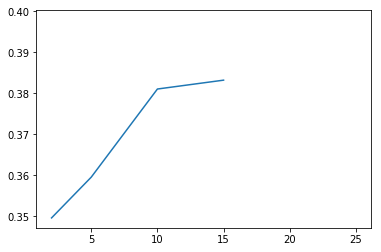

In [357]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(coherence_values_rev)

axcv = plt.figure(figsize=(6,4)).add_subplot(111)
plt.plot(dfcv.iloc[0].transpose())
#plt.xticks(list(range(1,20,1)))

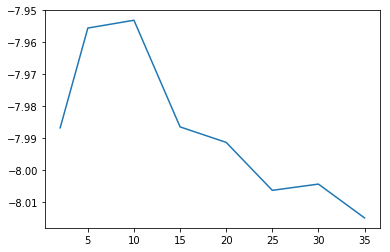

In [358]:
# perplexity
dfp = pd.DataFrame(grid_rev)
plt.plot((dfp.iloc[0].transpose()))
#plt.xticks(list(range(1,20,1)))
#plt.ylim(-8.1,-7.8)

In [ ]:
dfp.iloc[0][1]

In [ ]:
#np.exp(7.517)

# simple_process


In [ ]:
# Build the bigram and trigram models
%time bigram2 = gensim.models.Phrases(tokenized_text,\
                                     min_count=5, threshold=100) 
# higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
%time bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# Remove Stop Words
%time data_words_nostops2 = remove_stopwords(tokenized_text)
# Form Bigrams
%time data_words_bigrams2 = make_bigrams(bigram_mod2, data_words_nostops2)

In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
%time data_lemmatized2 = lemmatization(data_words_bigrams2,\
                                      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#create a Gensim dictionary from the texts
%time dictionary2= corpora.Dictionary(data_lemmatized2)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary2.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
#convert the dictionary to a bag of words corpus for reference
%time corpus2 = [dictionary2.doc2bow(text2) for text2 in data_lemmatized2]

In [ ]:
####### LDA model
%time ldamodel2 = models.LdaModel(corpus2, num_topics=20, \
                                   id2word=dictionary2, update_every=5,\
                                 chunksize=500, passes=20)

In [ ]:
# Get the topic related words 
topics_matrix2 = ldamodel2.show_topics(formatted=False, num_words=15, num_topics=15)
topics_matrix2 = np.array(topics_matrix2, dtype=object)
topic_words2 = topics_matrix2[:,1]

allls2 = []
allls12 = []
for k2 in range(len(topic_words2)):
    wordls2 = []
    for i2, v2 in topic_words2[k2]:
        wordls2.append(i2)
    print(wordls2)
    allls.append(wordls2)
    allls1.append([wordls2])

In [ ]:
dataprepared2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, dictionary2)
pyLDAvis.display(dataprepared2)

# calculate topic distribution

In [ ]:
from __future__ import absolute_import
import funcy as fp
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from past.builtins import xrange
#from . import prepare as vis_prepare


def _extract_data(topic_model, corpus, dictionary, doc_topic_dists=None):
    import gensim
    if not gensim.matutils.ismatrix(corpus):
        corpus_csc = gensim.matutils.corpus2csc(corpus, num_terms=len(dictionary))
    else:
        corpus_csc = corpus
        # Need corpus to be a streaming gensim list corpus for len and inference functions below:
        corpus = gensim.matutils.Sparse2Corpus(corpus_csc)

    vocab = list(dictionary.token2id.keys())
     # TODO: add the hyperparam to smooth it out? no beta in online LDA impl.. hmm..
    # for now, I'll just make sure we don't ever get zeros...
    beta = 0.01
    fnames_argsort = np.asarray(list(dictionary.token2id.values()), dtype=np.int_)
    term_freqs = corpus_csc.sum(axis=1).A.ravel()[fnames_argsort]
    term_freqs[term_freqs == 0] = beta
    doc_lengths = corpus_csc.sum(axis=0).A.ravel()

    assert term_freqs.shape[0] == len(dictionary), 'Term frequencies and dictionary have different shape {} != {}'.format(term_freqs.shape[0], len(dictionary))
    assert doc_lengths.shape[0] == len(corpus), 'Document lengths and corpus have different sizes {} != {}'.format(doc_lengths.shape[0], len(corpus))

    if hasattr(topic_model, 'lda_alpha'):
        num_topics = len(topic_model.lda_alpha)
    else:
        num_topics = topic_model.num_topics

    if doc_topic_dists is None:
        # If its an HDP model.
        if hasattr(topic_model, 'lda_beta'):
            gamma = topic_model.inference(corpus)
        else:
            gamma, _ = topic_model.inference(corpus)
        doc_topic_dists = gamma / gamma.sum(axis=1)[:, None]
    else:
        if isinstance(doc_topic_dists, list):
            doc_topic_dists = gensim.matutils.corpus2dense(doc_topic_dists, num_topics).T
        elif issparse(doc_topic_dists):
            doc_topic_dists = doc_topic_dists.T.todense()
        doc_topic_dists = doc_topic_dists / doc_topic_dists.sum(axis=1)

    assert doc_topic_dists.shape[1] == num_topics, 'Document topics and number of topics do not match {} != {}'.format(doc_topic_dists.shape[1], num_topics)

    # get the topic-term distribution straight from gensim without
    # iterating over tuples
    if hasattr(topic_model, 'lda_beta'):
        topic = topic_model.lda_beta
    else:
        topic = topic_model.state.get_lambda()
    topic = topic / topic.sum(axis=1)[:, None]
    topic_term_dists = topic[:, fnames_argsort]

    assert topic_term_dists.shape[0] == doc_topic_dists.shape[1]

    d =  {'topic_term_dists': topic_term_dists, 'doc_topic_dists': doc_topic_dists,
           'doc_lengths': doc_lengths, 'vocab': vocab, 'term_frequency': term_freqs}
    return d

In [ ]:
do = _extract_data(ldamodel, corpus, dictionary)

In [ ]:
dtt = pd.DataFrame(do['doc_topic_dists']).reset_index()

In [ ]:
dtt['year'] = df_clean['year']

In [ ]:
dttm = pd.melt(dtt, id_vars=['index','year'], value_vars=[0,1,2,3,4,5,6,7,8,9])

In [ ]:
dttm.rename(columns={'index':'doc_index','variable':'topic_no','value':'topic_weight'}, inplace = True)

In [ ]:
dtm1 = dttm.pivot(index='doc_index', columns='topic_no', values='topic_weight').fillna(0)

In [ ]:
dtm2 = dtm1.div(dtm1.sum(axis=1), axis=0)

# Shift back to a long dataframe
dt_norm2 = dtm2.stack().reset_index()
dt_norm2.columns = ['doc_index', 'topic_id', 'norm_topic_weight']

In [ ]:
len(text_ls)

In [ ]:
dt_norm21 = dt_norm2.merge(dttm[['year','doc_index']] ,on = 'doc_index').drop_duplicates()

In [ ]:
#text_ls[674]

In [ ]:
#wh[235]

In [ ]:
max_df = dt_norm21[dt_norm21.groupby(['doc_index'])['norm_topic_weight'].transform(max) == dt_norm21['norm_topic_weight']]

In [ ]:
topic1 = max_df[max_df['topic_id'] == 0]
topic1.sort_values('norm_topic_weight', ascending=False)

In [ ]:
max_counts = max_df[['doc_index', 'year', 'topic_id']].groupby(['year', 'topic_id']).agg({'doc_index' : 'count'}).reset_index()
max_counts.columns = ['year', 'topic_id', 'max_count']

In [ ]:
# Count the number of individual documents per year
total_docs = max_df[['year', 'doc_index']].groupby('year').agg({'doc_index' : 'count'}).reset_index()
total_docs.columns = ['year', 'total_docs']

In [ ]:
#total_docs

In [ ]:
# Combine the two dataframes
max_counts = max_counts.merge(total_docs, on='year', how='left')

In [ ]:
max_counts['prevalence'] = max_counts['max_count']/max_counts['total_docs']


In [ ]:
cm = plt.cm.get_cmap('tab10')
cm_skip = [cm.colors[i] for i in range(len(cm.colors))]

In [ ]:
xi = [
 2015,
 2016,
 2017,
2018]

In [ ]:
# ### TOPIC PREVALENCE
# #for key, data in max_counts.groupby('topic_id'):
# for i in range(0,10):
#     data = dy.merge(max_counts[max_counts['topic_id'] == i],
#                     on = 'year', how = 'left').fillna(0)
#     ax3 = data.plot(x='year', y='prevalence', 
#               label=key, color = cm_skip[i], legend = False, figsize = (11,2))
#     ax3.set_ylim(0,0.5)
#     #ax3.set_xlim(-0.5,0.5)
#     ax3.set_facecolor("white")
#     ax3.spines['left'].set_visible(False)
#     ax3.spines['right'].set_visible(False)
#     ax3.spines['top'].set_visible(False)
#     #ax2.set_ylim(0,250)
#     ax3.set_xlabel('')
#     plt.xticks(data['year'])
#     name = "Topic #" + str(i+1) +'pv_by_year21'
#     plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#     #plt.savefig('Figures/'+str(name)+'.png',dpi=800,facecolor='w',bbox_inches = 'tight')    
#     #plt.close()

In [ ]:
#max_counts.groupby('topic_id').count()
for key, data in max_counts.groupby('topic_id'):
    print(data)

In [ ]:
fig, ax4 =plt.subplots()
mylabels = ['Topic 1','Topic 2',
           'Topic 3','Topic 4',
           'Topic 5','Topic 6',
           'Topic 7','Topic 8',
           'Topic 9','Topic 10']
for key, data in max_counts.groupby('topic_id'):
    #data.plot(x='year', y='prevalence', ax=ax, label=key)
    #data = nn1
    ax4 = data.plot(x='year', y='prevalence', ax = ax4,
              label=key, color = cm_skip[key], figsize = (10,5))
    ax4.set_ylim(0,0.8)
    #ax3.set_xlim(-0.5,0.5)
    ax4.set_facecolor("white")
    ax4.spines['left'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    #ax2.set_ylim(0,250)
    ax4.set_xlabel('')
    plt.xticks(xi)
    #plt.xticks(data['year'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               labels=mylabels,frameon=False)
    #name = str(i+1) +'pv_by_p'
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    #plt.savefig('Figures/'+'90-97.png', dpi=800,facecolor='w',bbox_inches='tight')    
    #plt.close()

In [ ]:
pd.DataFrame(allls)

# Graph

In [ ]:
NUMDOCS = 60 # number of subreddits OR number of BBC documents per category
NUMTOPICS = 10
def toVector(l):
    ''' inserts 0s for unrepresented topics in a document
        input: return value from ldamodel.get_document_topics(corpus[i])
        output: document topics with 0s for unrepresented topics'''
    ret = []
    t = 0
    for i in range(NUMTOPICS):
        if t == len(l):
            ret += [0]
        elif l[t][0] == i + 1:
            ret += [l[t][1]]
            t = t + 1
        else:
            ret += [0]
    return ret

In [ ]:
#text_ls#

In [ ]:
EPS = 0.001
numDocs = len(text_ls)
# note: this can take a long time on large corpora
similarity = [[0 for x in range(numDocs)] for y in range(numDocs)]

for i in range(numDocs):
    itops = toVector(ldamodel.get_document_topics(corpus[i]))
    for j in range(numDocs)[i:]:
        jtops = toVector(ldamodel.get_document_topics(corpus[j]))
        sim = 1.0 - gensim.matutils.hellinger(itops, jtops)
        sim = min(sim + EPS, 1.0)
        
        similarity[i][j] = sim


In [ ]:
type(similarity)

In [ ]:
import pickle

In [ ]:
with open('similarity','wb') as f:
    pickle.dump(similarity,f)

In [ ]:
d = pickle.load(open('similarity', 'rb'))

In [ ]:
len(d)

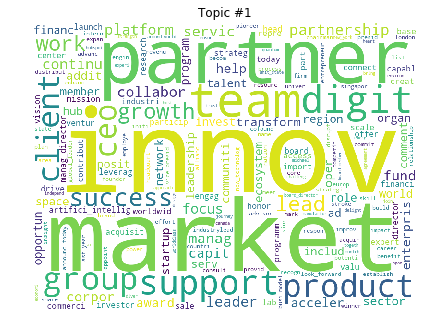

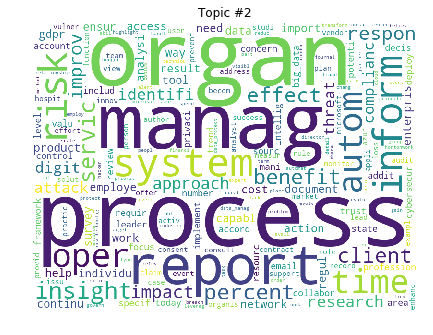

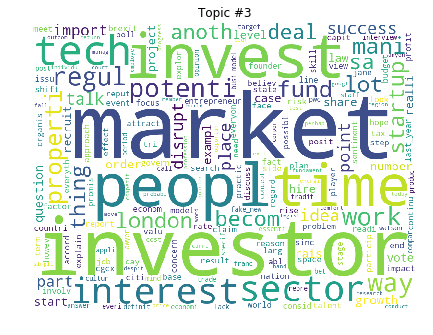

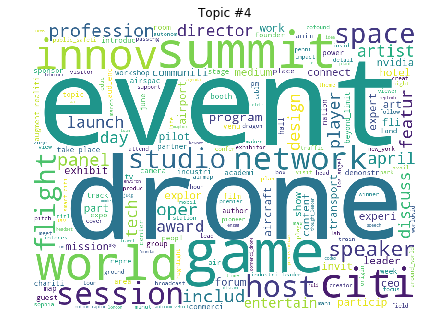

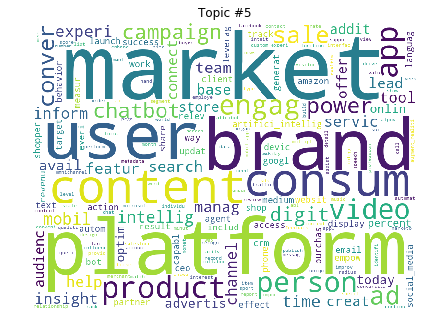

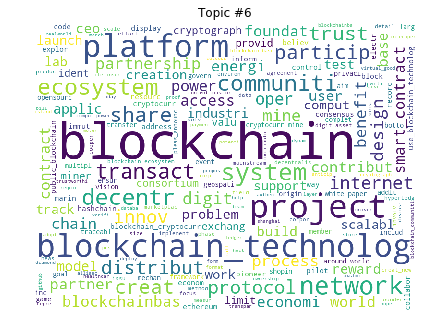

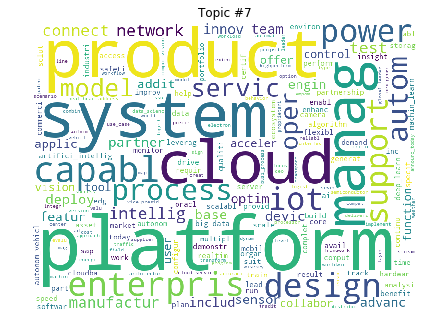

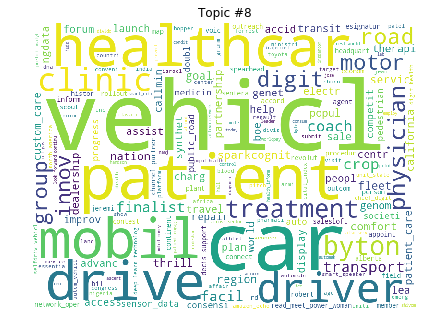

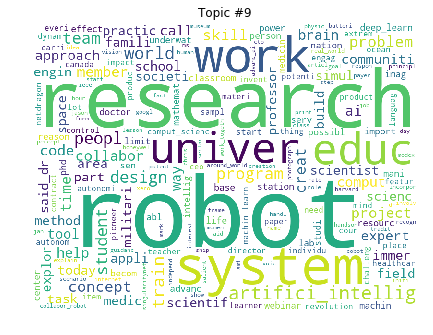

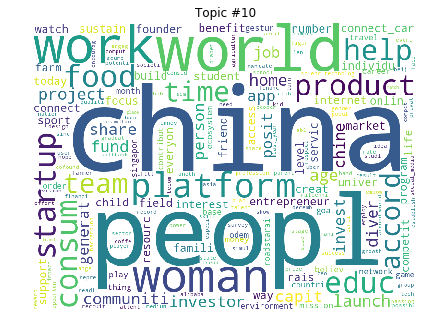

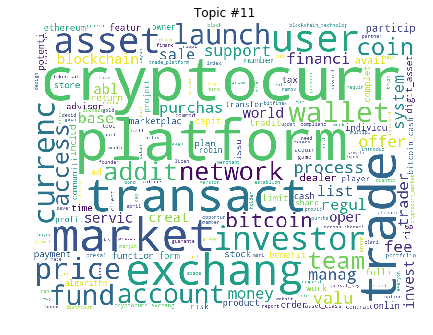

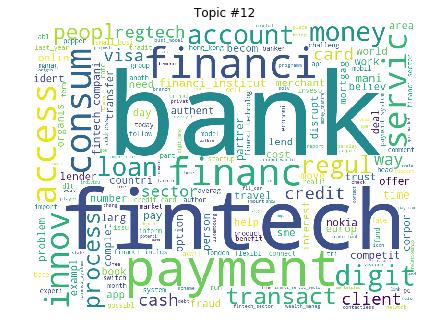

In [242]:
# Wordclouds
wc = WordCloud(
    background_color="white",
    max_words=200,
    width=800,
    height=600,
    stopwords= stops#,
    #colormap = "Greens"#stopwords.words('english')
)
#WordCloud().fit_words(dict(lda.show_topic(t, 200)))
for t in range(ldamodel.num_topics):
    name = "Topic #" + str(t+1)
    plt.figure().subplots_adjust(bottom=0, top=1, left=0, right=1)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    
    #plt.savefig(str(name)+'.png', dpi=300,facecolor='w',bbox_inches="tight", pad_inches = 0)
    #plt.close()
    #plt.close()
    #plt.show()